# Theory of Regression and Regularization

### Data Science 350
### Stephen F Elston

In this notebook we will explore the mathematical basis of linear statistical models. The emphasis is on ubiquitious problem of **model overfitting** or **model over-parameterizaton**. 

Overfitting or over-parameterizatio of machine learning models arrises in any case where the number of model parameters exceeds the effective dimensions of the feature set. This is most often the result of linear dependency between the features. However, using too complex a model can lead to similar problems. In the extreme case, imagine a model with as many free parameters as training cases. This model might fit the training data perfectly, but will show unstable and unexpected results when used for any other data. In machine learning terminology, we say that such an unstable model does not **generalize**. 

Many methods have been developed and continue to be developed to deal with over-paramterized or **ill-posed** machine learning models. In particular, in this notebook we will explore three methods for stabalizing over-parameterized models. 

- Stepwise regression, wherein features are eliminated from an over-parameterized model in a stepwise fashon.
- Using a mathematical **regularization** technique, known as singular value decomposision, to determine the number of meaningful components for a model. 
- Using **regularizaton** methods known as ridge regression and lasso regression to stabalize over-parameterized models. 

![](img/Extrapolation.png)
<center> **Warning!! Extrapolation can be dangerious!!**


***
**Note:** To run the code in this note book you must have installed the following packages:
- HistData
- dplyr
- ggplot2
- gridExtra
- MASS
- glmnet
***

## Stepwise Regression

In this section we will work through an example of stepwise regression using the Gaulton family height data. The goal of the model is to predict the hight of adult childern given informaiton on the height of their parents. 

### Preparing the data

As a first step we will create a data set for just the adult male childern. The code in the cell below performs the following operations:

- Subset the data to just male adult childern.
- Compute two new feaures, the heights of the parents squared.
- Zscore scale the features.

Execute this code to prepare the data. 

In [1]:
require(HistData)
require(dplyr)
males = GaltonFamilies[GaltonFamilies$gender == 'male',]
males.ext = males[, c('mother', 'father', 'childHeight')]
males.ext = mutate(males.ext, mother.sqr = mother^2, father.sqr = father^2)
males.ext[, c('mother', 'father', 'mother.sqr', 'father.sqr')] = 
        lapply(males.ext[, c('mother', 'father', 'mother.sqr', 'father.sqr')], 
               scale)
str(males.ext)

Loading required package: HistData
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



'data.frame':	481 obs. of  5 variables:
 $ mother     : num [1:481, 1] 1.2779 1.0625 1.0625 -0.0143 -0.0143 ...
  ..- attr(*, "scaled:center")= num 64
  ..- attr(*, "scaled:scale")= num 2.32
 $ father     : num [1:481, 1] 4.06 2.76 2.76 2.54 2.54 ...
  ..- attr(*, "scaled:center")= num 69.1
  ..- attr(*, "scaled:scale")= num 2.31
 $ childHeight: num  73.2 73.5 72.5 71 70.5 68.5 72 69 68 76.5 ...
 $ mother.sqr : num [1:481, 1] 1.2958 1.0702 1.0702 -0.0326 -0.0326 ...
  ..- attr(*, "scaled:center")= num 4106
  ..- attr(*, "scaled:scale")= num 296
 $ father.sqr : num [1:481, 1] 4.31 2.86 2.86 2.63 2.63 ...
  ..- attr(*, "scaled:center")= num 4785
  ..- attr(*, "scaled:scale")= num 320


### Computing a model with all features

As a first step, let's compute a model for the hight of the adult male childern using all available features. Execute the code in the cell below to compute this model, and print and plot evaluation information. 


Call:
lm(formula = childHeight ~ ., data = males.ext)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.5150 -1.5506  0.1913  1.5282  9.1044 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  69.2341     0.1048 660.506   <2e-16 ***
mother       -2.0659     4.1774  -0.495    0.621    
father        2.3489     4.0186   0.584    0.559    
mother.sqr    2.8319     4.1785   0.678    0.498    
father.sqr   -1.3913     4.0197  -0.346    0.729    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.299 on 476 degrees of freedom
Multiple R-squared:  0.2388,	Adjusted R-squared:  0.2324 
F-statistic: 37.33 on 4 and 476 DF,  p-value: < 2.2e-16


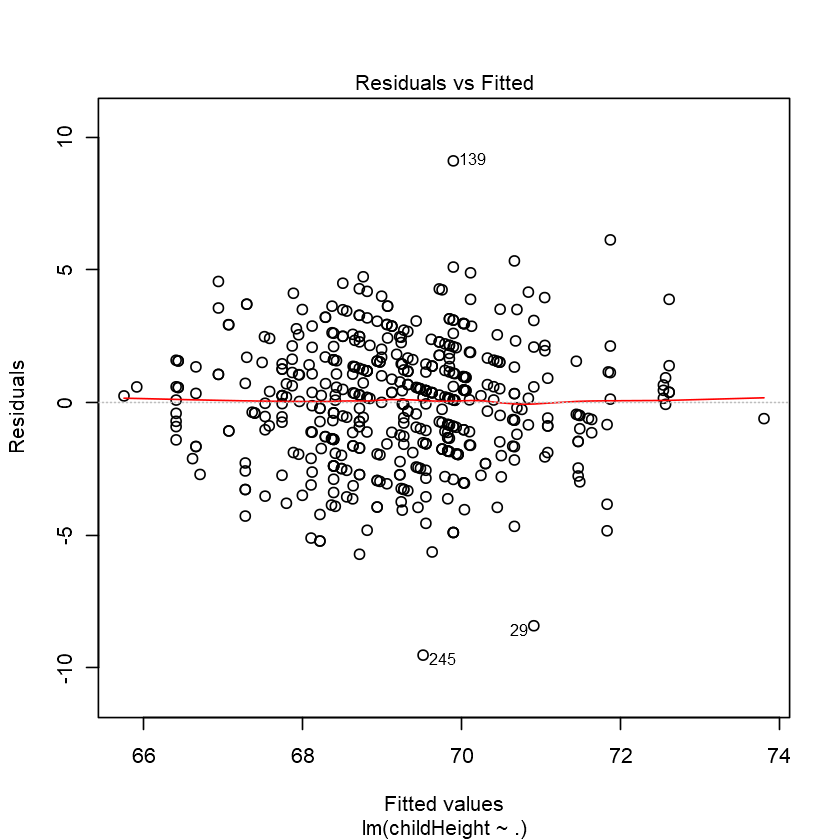

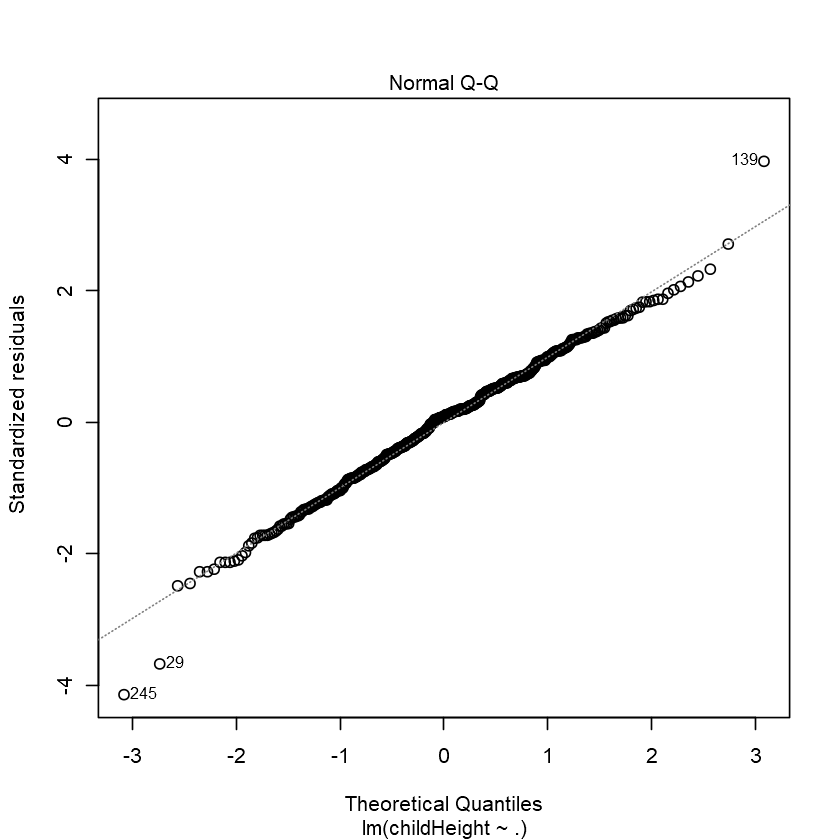

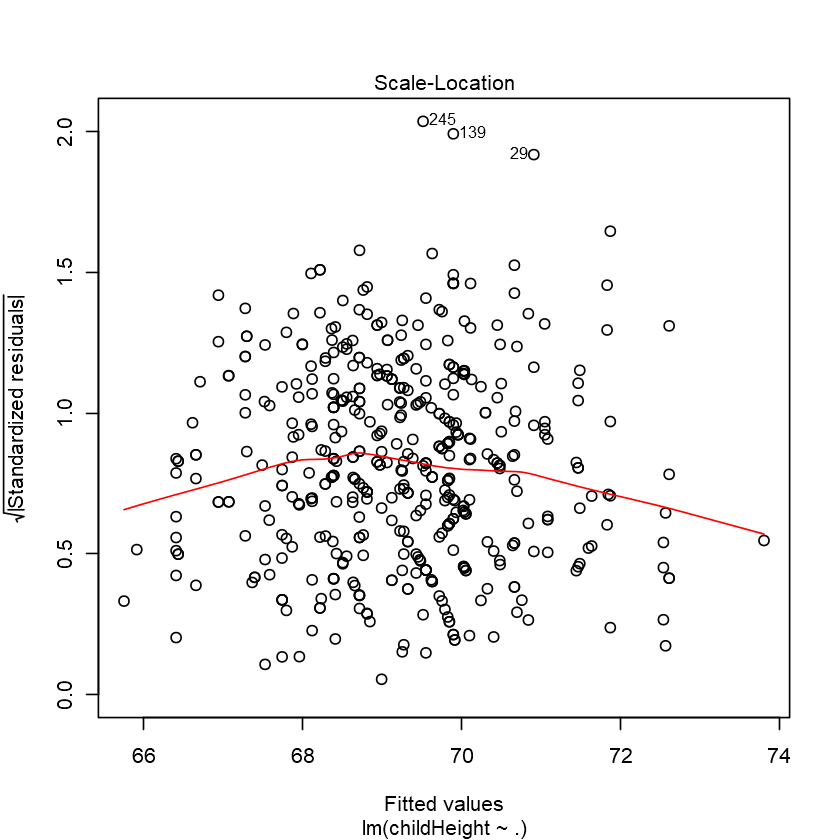

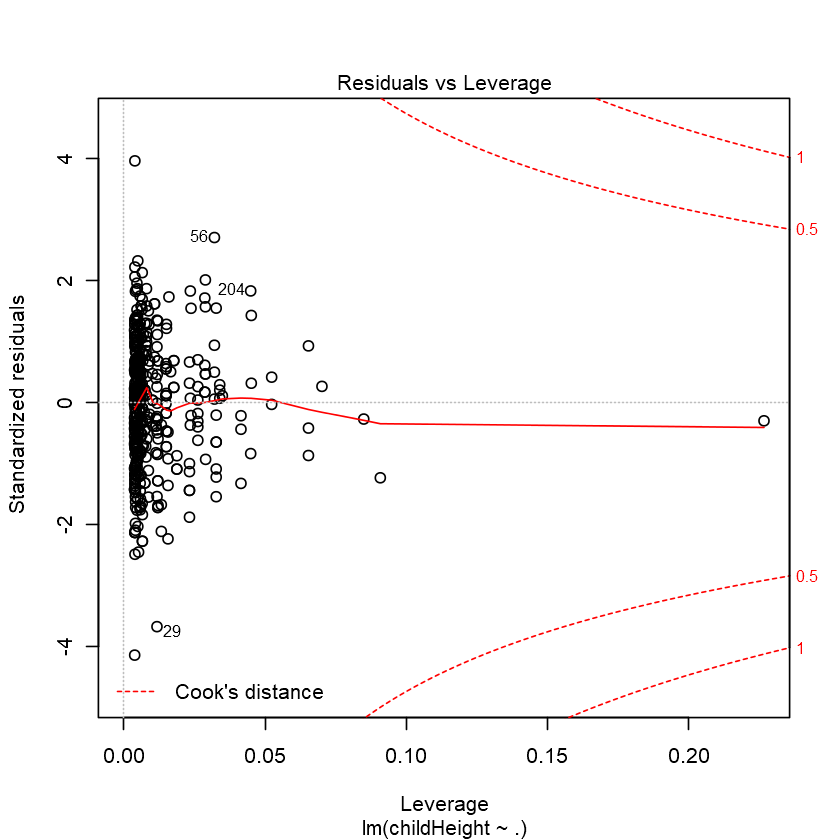

In [2]:
lm.males = lm(childHeight ~ ., data = males.ext)
summary(lm.males)
plot(lm.males)

It is clear from the summary that this model is over-parameterized. Only the intercept is significant. In other words, we are computing the average value of the lable (childHeight), but nothing more. Examination of the residual plots shows them to be mostly well behaved, except with a bit of curvature in the standardized residual plot. 

### Apply stepwise regression

Stepwise regression using model performance metrics to prune the number of features in a model. The steps can be forward, wherein features are added one at a time in order of importance, until a point of diminished return is reachec. Or, the steps can be backward, wherein a model using all features is puruned one feature at a time in reverse order of importance. It is also possible to step in both directions. In practice, either backward steps of using both directions are used, since forward steps have a tendancy to get stuck at poor solutions. 

A significant issue with stepwise regression is to choose a performance metric. Many commonly used error metrics like RMSE will natually get better as we add more model parameters. Consequently the **Akaike information criterion** (AIC) is often used. We can write the AIC as:

$$AIC = 2 k - 2 ln(\hat{L})\\
where\\
\hat{L} = the\ likelihood\ given\ the\ fitted\ model\ parmaters\ \hat\theta = p(x| \hat\theta)\\
x = observed\ data\\
k = number\ of\ model\ parameters$$

In words, the AIC is the model log-likelihood adjusted for the number of model parameters. The objective is to minimize the AIC. 

The quantity $- 2 ln(p(x| \hat\theta))$ is sometimes reffered to as the **deviance** of the model. Deviance is a measure of the relative likelihood of the model. Deviance is a generalization of the variance. I fact, deviance should be meaured with respect to a staturated model (number of parmeters = number of observations), but this step is often skipped.

The R `MASS` library contains the `stepAIC` function which uses the AIC to perform stepwise regression on the model. Execute this code and examine the results. 


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select



Start:  AIC=805.76
childHeight ~ mother + father + mother.sqr + father.sqr

             Df Sum of Sq    RSS    AIC
- father.sqr  1   0.63311 2516.2 803.88
- mother      1   1.29252 2516.9 804.01
- father      1   1.80550 2517.4 804.11
- mother.sqr  1   2.42749 2518.0 804.23
<none>                    2515.6 805.76

Step:  AIC=803.88
childHeight ~ mother + father + mother.sqr

             Df Sum of Sq    RSS    AIC
- mother      1      1.13 2517.3 802.10
- mother.sqr  1      2.20 2518.4 802.30
<none>                    2516.2 803.88
+ father.sqr  1      0.63 2515.6 805.76
- father      1    435.77 2952.0 878.71

Step:  AIC=802.1
childHeight ~ father + mother.sqr

             Df Sum of Sq    RSS    AIC
<none>                    2517.3 802.10
+ mother      1      1.13 2516.2 803.88
+ father.sqr  1      0.47 2516.9 804.01
- mother.sqr  1    278.59 2795.9 850.58
- father      1    440.17 2957.5 877.61


Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
,NA,NA,476,2515.579,805.7622
- father.sqr,1,0.6331102,477,2516.213,803.8832
- mother,1,1.1274094,478,2517.340,802.0987



Call:
lm(formula = childHeight ~ father + mother.sqr, data = males.ext)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.5264 -1.5642  0.1983  1.5130  9.0977 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  69.2341     0.1046 661.661  < 2e-16 ***
father        0.9614     0.1052   9.142  < 2e-16 ***
mother.sqr    0.7649     0.1052   7.273 1.45e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.295 on 478 degrees of freedom
Multiple R-squared:  0.2383,	Adjusted R-squared:  0.2351 
F-statistic: 74.76 on 2 and 478 DF,  p-value: < 2.2e-16


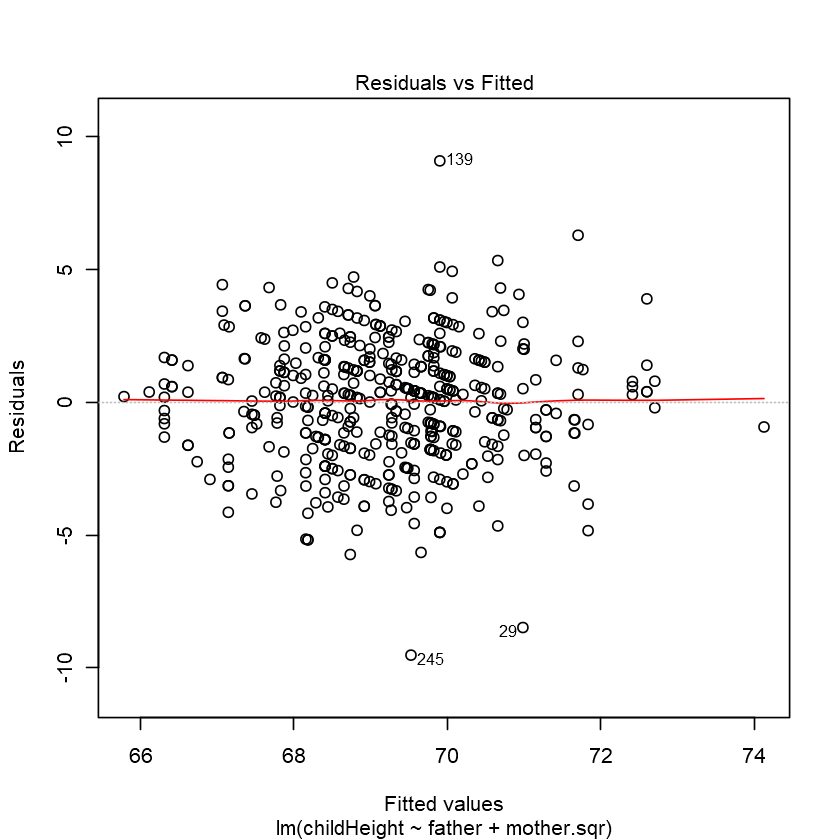

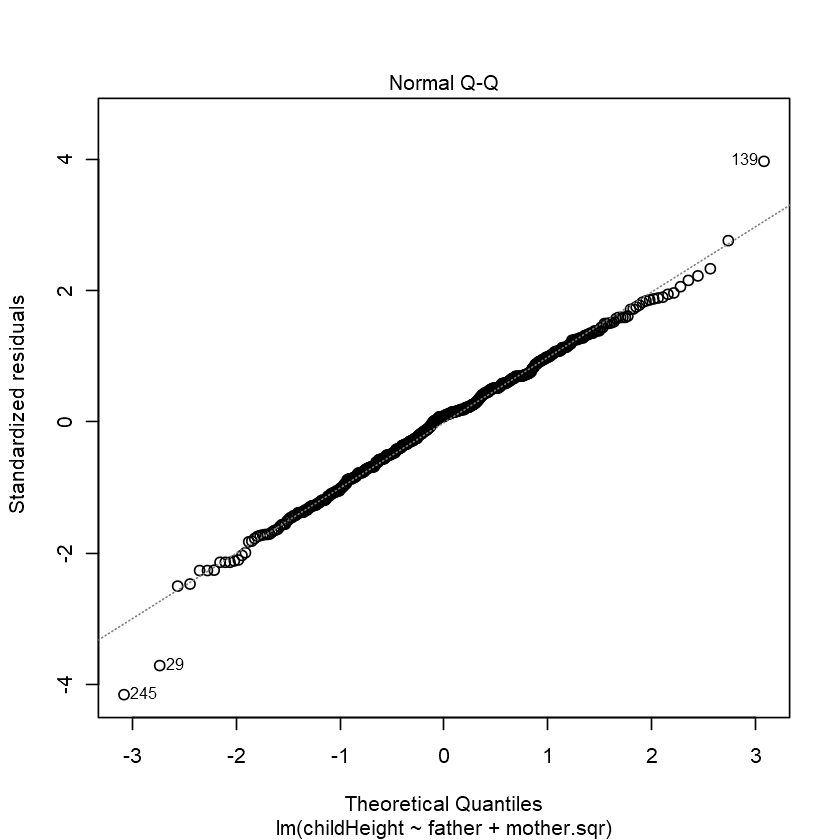

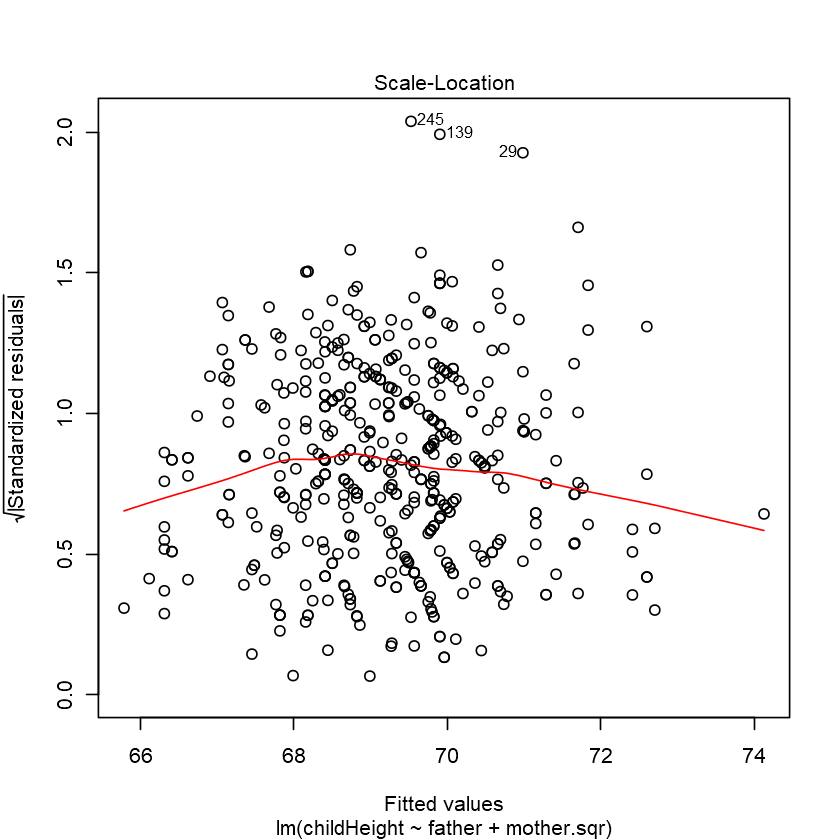

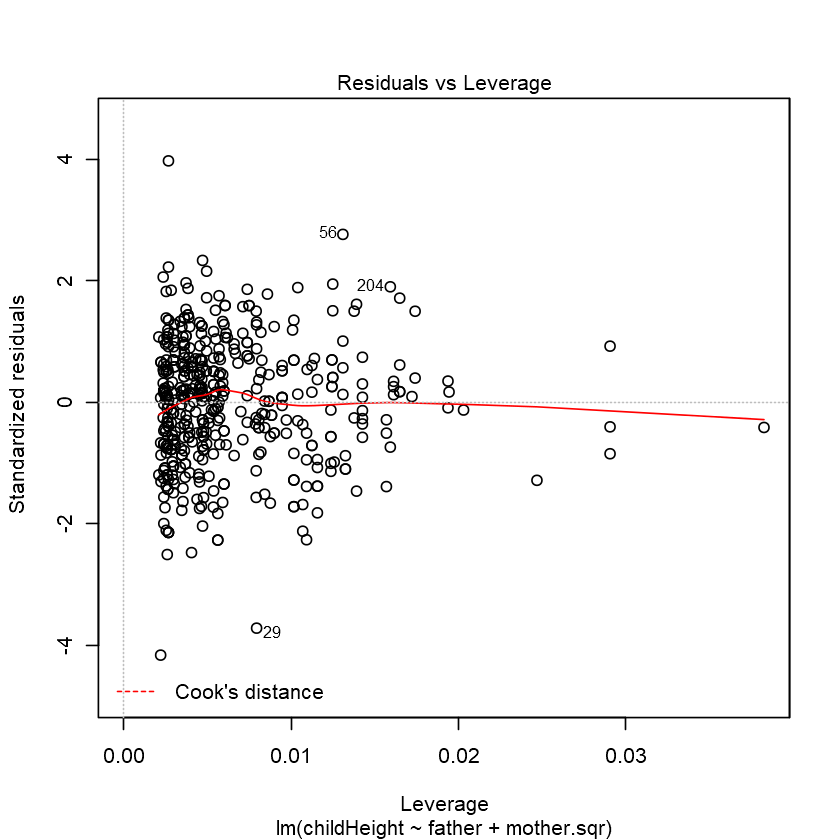

In [3]:
library(MASS)
lm.step = stepAIC(lm.males, direction = 'both')
lm.step$anova # ANOVA of the result 
summary(lm.step) # Summary of the best model
plot(lm.step)

The summary of `stepAIC` shows the steps taken. In the first step the model without `father.sqr` has the lowest AIC, so this feature is pruned. In the next step, the model eliminating `mother` has the lowest AIC, and so this feature is pruned. At the last step, the model which eleminates no features, denoted `<none>` has the best AIC. 

The three coeficients for the final model are now all significant. The residual plots show similar behavior to the intial model.

### Adding an interaction term

We will try one last idea, adding an interaction term. In this case we will compute all possbile interactions between the heights of the mother and the father, `mother`, `father`, `mother times father`. 

Execute the code in the cell below to compute the model and print and plot the results. 


Call:
lm(formula = childHeight ~ mother * father, data = males.ext)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.5351 -1.5428  0.2078  1.4898  9.0870 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   69.22986    0.10508 658.861  < 2e-16 ***
mother         0.76052    0.10540   7.216 2.12e-12 ***
father         0.95966    0.10543   9.102  < 2e-16 ***
mother:father  0.04853    0.09593   0.506    0.613    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.297 on 477 degrees of freedom
Multiple R-squared:  0.2383,	Adjusted R-squared:  0.2336 
F-statistic: 49.76 on 3 and 477 DF,  p-value: < 2.2e-16


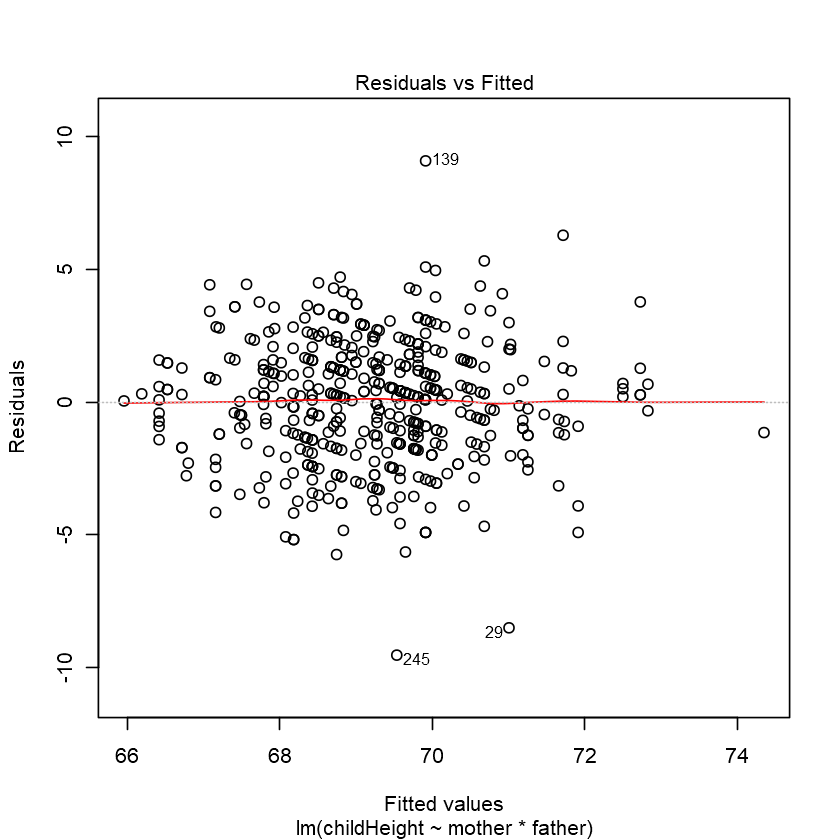

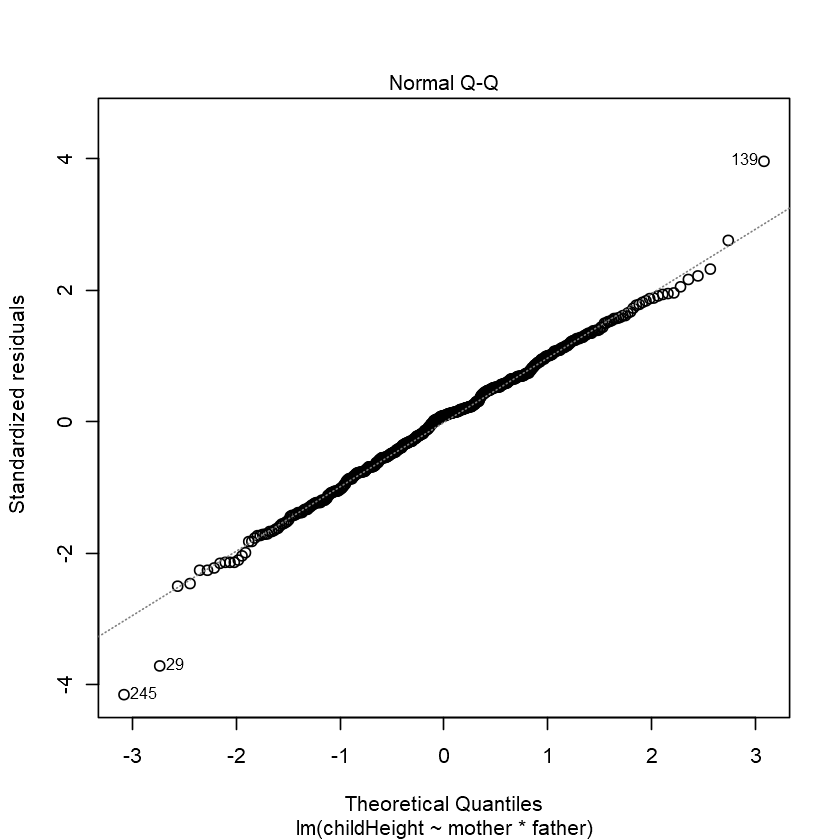

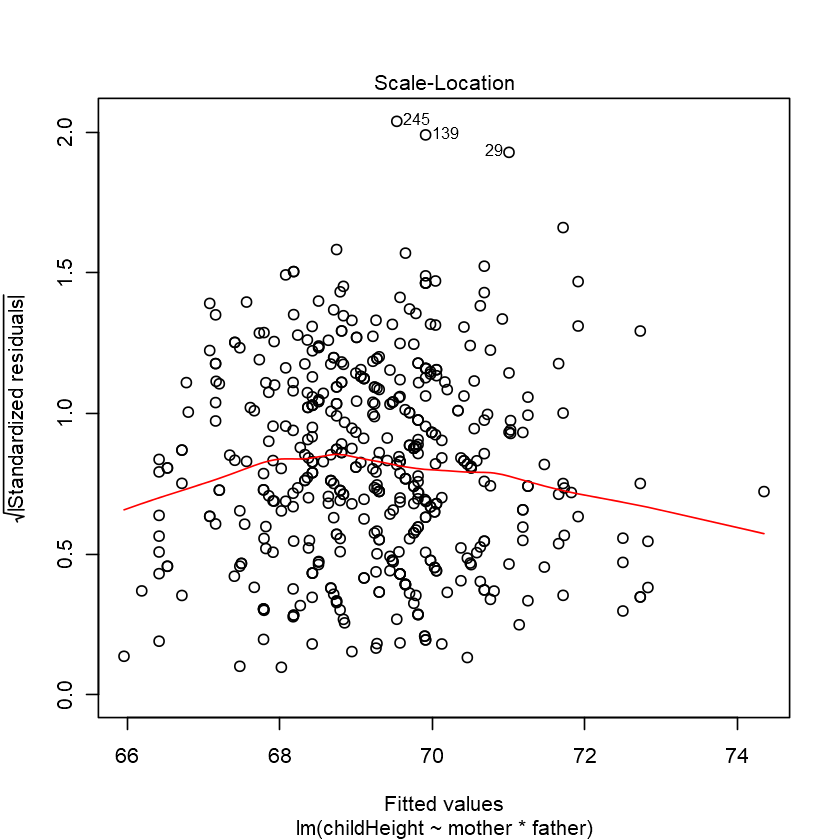

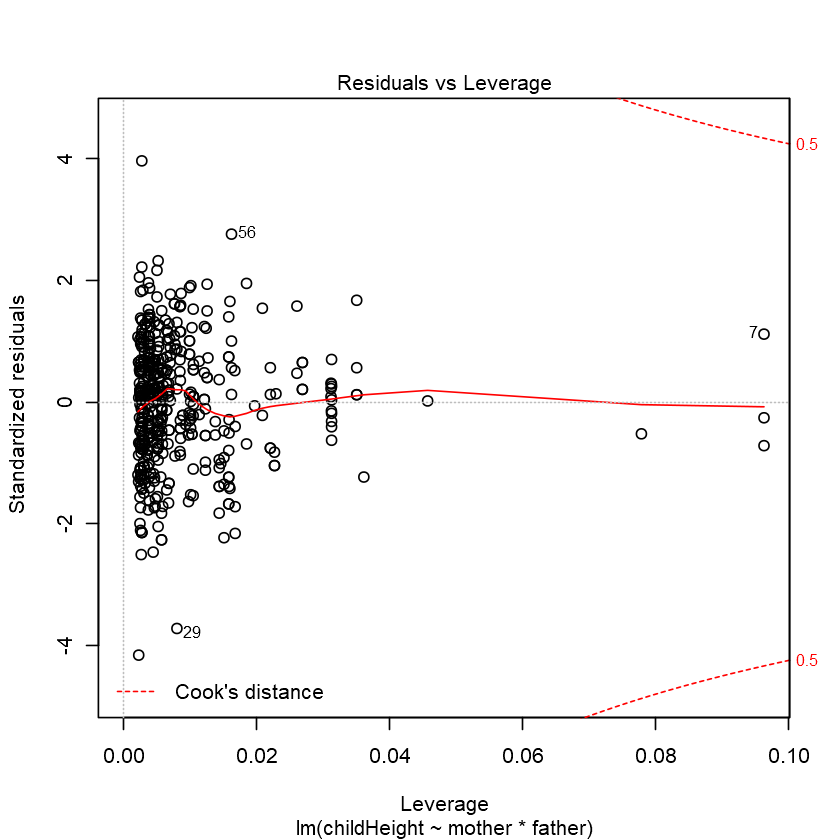

In [4]:
lm.interaction = lm(childHeight ~ mother*father, data = males.ext)
summary(lm.interaction)
plot(lm.interaction)

It is clear from the summary that the interaction term is not significant. The best model we have to this point is the one computed with stepwise regression. 

***
**Note:** Stepwise regression appears to be a simple method for feature selection. However, be aware that **stepwise regresson does not scale well**. As with any multiple comparison method, stepwise regresson suffers from a high probability of false positive results. In this case, a feature which should be dropped might not be, because of a low p-value or AIC. 
***

## Regularization 1, Singular Value Decomosition

Now that we have explored both manual feature selection and stepwise regression, we will examine regularization methods. Regularization methods stabalize the inverse of the **model matrix**. In this section we will use the singular value decomposition method to stabalize a model matrix. 

You may well wonder why we need regularization methods, when we have tools like stepwise regression. Two improtant reasonse are:

- Stepwise regression is a compuationally intensive process, since we must recompute the model many times. There are methods that allow computation of the updated model, but with a large number of features there are numerious permutations. We need methods that can handel hundres, thousands, and even millions of features. 
- With stepwise regression a feature is either in or out of the model. This may not be the best choise. Perhaps a reweighting the features in some way might be better. 
- Stepwise regression suffers from issues inherent in multiple comparisons. 

### Linear Algebra Review

Before we get into the details of regularizaton, let's review some basic linear algebra.

**Note**, a simple reference guide to common linear algebra operations in R can be found at on the [Quick R website](http://www.statmethods.net/advstats/matrix.html)

Let's start by creating two vectors of length 3.

In [5]:
a = rep(2, 3)
a
b = 1:3
b

[1] 2 2 2

[1] 1 2 3

We can perform some basic element-wise arithmetic opertions on vectors.

In [6]:
a + b
a * b

[1] 3 4 5

[1] 2 4 6

We can also compute the **dot product**, **scalar product** or **inner product** of two vectors of equal lenght.

$$dot\ product = \Sigma_i^n a_i \cdot b_i$$

Give this a try by executing the code in the cell below.

In [7]:
t(a) %*% b

12


The square root of the inner product of a vector with itself is the length or $L2$ norm of the vector.

$$\parallel a \parallel = length\ of\ vector\ a = \sqrt{a \cdot a}$$

**Your Turn:** Create and exectue the code to compute the length or norm of the vector `a` in the cell below.

In [8]:
sqrt(t(a) %*% a)

3.464102


We can also write the inner product as:

$$a \cdot b = \parallel a \parallel \parallel b \parallel cos(\theta)\\
or \\
cos(\theta) = \frac{a \cdot b}{\parallel a \parallel \parallel b \parallel}$$

Notice that the inner product of orthogonal vectors is $0$. Run the code in the cell below to see an example.

In [9]:
aa = c(1, 0, 0)
bb = c(0, 1, 1)
t(aa) %*% bb

0


Let's try some operations on martricies. Let $A$  and $B$ be $m = 4$ rows by $n = 3$ columns matrices. 

In [10]:
A = matrix(4, nrow = 4, ncol = 3)
A
B = matrix(1:12, nrow = 4, ncol = 3)
B

4,4,4
4,4,4
4,4,4
4,4,4


1,5,9
2,6,10
3,7,11
4,8,12


We can perform some arithmatic operations element by element on these matrces.

In [11]:
A + B
A * B

5,9,13
6,10,14
7,11,15
8,12,16


4,20,36
8,24,40
12,28,44
16,32,48


We can multiply a $mxn$ matrix by a vector of length $n$ by taking the inner product of each row of the matrix and the vector. The result in a vector of length $n$. Each element of the result can be written at:

$$y_i = \Sigma_j^m A_{ij} \cdot b_j$$

Run the code in the cell below and examine the result. 

In [12]:
A %*% b

24
24
24
24


So, how do we multipy two matrices? In matrix multiplcation each element of the resulting matrix is the inner product of a row by a column. For example, the element $Y_{ij}$ of the result matrix is computed as follows:

$$Y_{ij} = \Sigma_j^m A_{ij} \cdot B_{ji}$$

Notice that the number of columns, $m$, of the first matrix must equal the number of rows of second matrix. And, that the number of rows, $n$ of the first matrix must equal the number of columns of the second metrix. In this case, the two matricies are said to be **conformable**. 

Give matrix multiplication a try by exectuing the code in the cell bellow.

In [13]:
A %*% B

ERROR: Error in A %*% B: non-conformable arguments


That operation failed! Evidently these matrices are not conformable. 

But, what if we take the transpose of $B$? The **transpose** of a matrix is just that matrix with the row and column indicies permuted like this:

$$B_{ji}^T = B_{ij}\\
where \\
B\ has\ dimensions\ n x m \\
and \\
B^T\ has\ dimensions\ m x n$$ 

If we multiply an $n x m$ matix by an $m x n$ matrix the result is a square $n x n$ matrix. 

**Your Turn:** create and execute the code in the cell below to multiply the matrix A by the transpose of B. Use the R `t()` function to take the transpose of the matrix:

In [14]:
t(A) %*% B 
AB = A %*% t(B)

40,104,168
40,104,168
40,104,168


We can define the **indentity** matrix having ones on the diagonal and zeros elsewehere.

$$I = \begin{bmatrix}
    1  & 0 & 0 & \dots & 0 \\
    0  & 1 & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & 1
\end{bmatrix}$$

The identity multiplied by any matrix gives that matrix. If $AB$ is a rectangular matrix then:

$$AB = I \cdot AB = AB \cdot I$$

In [15]:
I = diag(c(1, 1, 1, 1))
I
AB %*% I
I %*% AB

1,0,0,0
0,1,0,0
0,0,1,0
0,0,0,1


60,72,84,96
60,72,84,96
60,72,84,96
60,72,84,96


60,72,84,96
60,72,84,96
60,72,84,96
60,72,84,96


In principle we can compute an inverse of a matrix so that:

$$A = A\\
A = AI \\
A^{-1}A = I$$

In machine learning, we often encounter matricies where cannot be inverted directrly. Instead, we need a decompositon of $A$ that alows us to compute $A^{-1}$. One possibility is a method called singular value decomposiion or SVD:

$$svd(A) = U D V^{\ast}$$

Where,
- $U$ are the orthogonal unit norm left singular vectors.
- $V$ are the orthogonal unit norm right singular vectors, and $V^{\ast}$ is the conjugate transpose. For real-valued $A$ this is just $V^T$.
- $D$ is a diagonal matrix of singular values, which are said to define a **spectrum**.
- $A$ is comprised of the linear combination of singular vectors scaled by singular values.

To compute the SVD of a matrix and view the results execute the code in the cell below.

In [70]:
SVD = svd(B)
SVD

-0.4036176,-0.7328662,-0.2819388
-0.4647441,-0.2898498,0.7259267
-0.5258707,0.1531666,-0.6060371
-0.5869972,0.5961831,0.1620492
-0.2067359,0.8891533,-0.4082483
-0.5182887,0.2543818,0.8164966
-0.8298416,-0.3803896,-0.4082483


You can verify that the singular vectors form a orthonomal basis by executing the code in the cell below:

In [71]:
t(SVD$u) %*% SVD$u
SVD$v %*% t(SVD$v)

1.000000e+00,0.00000e+00,1.110223e-16
0.000000e+00,1.00000e+00,1.942890e-16
1.110223e-16,1.94289e-16,1.000000e+00


1.000000e+00,5.551115e-17,0
5.551115e-17,1.000000e+00,0
0.000000e+00,0.000000e+00,1


The result are two identity matricies, one of dimension $n x n$ and the other of dimenstion $m x m$.

We can view the product of the matrix $A$ with a vector as defining a rotation and scaling. The singular value decomposition of $A$ can be viewe as:

- A first rotation defined by the unit norm singular values $V^{\ast}$.
- A scaling defined by the diagonal singular value matrix $D$.
- A second rotation defined by the unit norm singular values $U$.

This geometric interpertation can be visualized as shown in the figure below.

![](img/SVD.png)

Execute the code in the cell below and examine the rotations and scaling of the inital vector.

In [72]:
e = sqrt(1/3)
u = c(e, e, e)
u
sqrt(u %*% u)
cat('The first rotation')
u = t(SVD$v) %*% u
u
sqrt(t(u) %*% u)
cat('The scaling')
u = diag(SVD$d) %*% u
u
sqrt(t(u) %*% u)
cat('The second rotation')
u = SVD$u %*% u
u
sqrt(t(u) %*% u)

[1] 0.5773503 0.5773503 0.5773503

1


The first rotation

-8.977024e-01
4.406023e-01
-2.775558e-17


1


The scaling

-2.283471e+01
7.589869e-01
-4.006225e-32


22.84732


The second rotation

8.660254
10.392305
12.124356
13.856406


22.84732


**Your Turn:** Do the following:
- Demonstrate that the matrix `B` gives the same rotation and scale by multipling a vector `u = c(e, e, e)`. 
- Verify that the singular value decomposition is equal to the original matrix. Compute $U D V^T$. Make sure you use the full diagonal matrix of the singular values using the R code, `diag(SVD$d)`. 

In [73]:
BB = B %*% c(e, e, e)
BB
sqrt(sum(t(BB) %*% BB))
SVD$u %*% diag(SVD$d) %*% t(SVD$v)

8.660254
10.392305
12.124356
13.856406


[1] 22.84732

1,5,9
2,6,10
3,7,11
4,8,12


The question now is, how do we compute $A^{-1}$ from its SVD? In most cases, there is no exact representation. But, we can come close using the **pseudo inverse** also known as the **Moore-Penrose inverse**, which is defined as:

$$A^\dagger = V D^+ U^*$$

Where,

- $D^+$ is the square diagonal matrix of **inverse sigular values** significantly greater than $0$. All other terms are set to $0$.
- $U^*$ is the transpose of the right sigular value matrix. 
- $V$ is the left singular value matrix.

The matrix, $A$ may not be of full rank. The types of long and narrow $n x m$ matricies we encounter in machine learning are typically **rank deficient**. A rank deficient matrix arrises when there is linear dependency between one or more of the columns. As an example, a matrix with correlated (not necessiarily perfectly correlated) columns is bound to be rank deficient. 

A matrix is considered rank deficient if it has one or more of the $m$ sigular values  $d_i  \sim 0.0$. In this case we substitute $0.0$ values on the diagonal of $D^+$ where the singular values $d_i \sim 0.0$. In fact, we want $d_i$ to be significanlty greater than $0$. 

Let's try an example. The code in the cell below computes the SVD of a matrix of random numbers chosen from a Normal distribution. The pseudo inverse is computed and multiplied by the original matrix. Execute this code and note the result.

In [74]:
cat('Create a matrix of random values')
C = matrix(rnorm(9), nrow = 3, ncol = 3)
C
cat('Compute the SVD and look at the sigular values')
CSVD = svd(C)
CSVD$d
cat('The inverse matrix of sigular values')
D = diag(1/CSVD$d)
D
cat('The pseudo inverse of the matrix')
cInv = CSVD$v %*% D %*% t(CSVD$u)
cInv
cat('The pseudo inverse times the matrix')
cInv %*% C

Create a matrix of random values

-1.0662679,0.1999814,0.02869228
0.8755639,0.6914502,-0.61135473
0.1826047,1.1200884,0.75570295


Compute the SVD and look at the sigular values

[1] 1.5679478 1.3123551 0.6888442

The inverse matrix of sigular values

0.6377763,0.0000000,0.000000
0.0000000,0.7619889,0.000000
0.0000000,0.0000000,1.451707


The pseudo inverse of the matrix

-0.8517498,0.08394632,0.1002505
0.5455636,0.57217406,0.4421683
-0.6028109,-0.86834985,0.6436739


The pseudo inverse times the matrix

1.000000e+00,-8.326673e-17,-2.081668e-16
3.885781e-16,1.000000e+00,3.885781e-16
0.000000e+00,-2.220446e-16,1.000000e+00


First, notice that the singular values are of similar magnitude and none are near zero. This matrix is not rank deficient. 

Let's try another example. The code in the cell below does the following:

- Creates a $4 X 4$ matrix of numbers drawn from a Normal distribution.
- Substitues values in the 4th column which are a linear combination of the other three columns.
- Computes the SVD of this matrix.
- Creates the inverse diagonal matrix of singular values.
- Computes the pseudo inverse of the matrix.
- Multiplies the pseudo inverse by the original matrix. 

Execute this code and examine the result.

In [75]:
cat('Create a matrix of random values')
C = matrix(rnorm(16), nrow = 4, ncol = 4)
C[, 4] = 0.4 * C[, 1] + 0.2 * C[, 2] + 0.4 * C[, 3]
C
cat('Compute the SVD and look at the sigular values')
CSVD = svd(C)
CSVD$d
cat('The inverse matrix of sigular values')
D = diag(1/CSVD$d)
D
cat('The pseudo inverse of the matrix')
cInv = CSVD$v %*% D %*% t(CSVD$u)
cInv
cat('The pseudo inverse times the matrix')
cInv %*% C

Create a matrix of random values

-0.5557795,-0.90677812,1.3640838,0.14196606
-0.8048404,1.41899427,1.0080858,0.36509701
-0.2885548,0.01315971,0.5115738,0.09183951
0.2625159,-1.46200450,1.4640057,0.39820776


Compute the SVD and look at the sigular values

[1] 2.6920358 2.0500698 0.4846155 0.0000000

The inverse matrix of sigular values

0.3714661,0.0000000,0.000000,0
0.0000000,0.4877883,0.000000,0
0.0000000,0.0000000,2.063492,0
0.0000000,0.0000000,0.000000,Inf


The pseudo inverse of the matrix

-Inf,-Inf,Inf,Inf
-Inf,-Inf,Inf,Inf
-Inf,-Inf,Inf,Inf
Inf,Inf,-Inf,-Inf


The pseudo inverse times the matrix

NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN


Notice the following about this result:

- The 4th singular value is nearly zero. Evidently, this matrix is rank deficient. 
- The product of the pseudo inverse is not close to being the identity matrix. This is the result of taking using the unstable inverse of the rank deficient matrix.

**Your Turn:** In the cell below do the following:

- Set the inverse of the smallest singular value to zero.
- Compute the pseudo inverse.
- Compute the product of the pseudo inverse and the orginal matrix. 
- Note if the result is closer to an identity matrix. 

In [76]:
D = diag(1/CSVD$d)
D[4,4] = 0.0
D
cat('The pseudo inverse of the matrix')
cInv = CSVD$v %*% D %*% t(CSVD$u)
cInv
cat('The pseudo inverse times the matrix')
cInv %*% C

0.3714661,0.0000000,0.000000,0
0.0000000,0.4877883,0.000000,0
0.0000000,0.0000000,2.063492,0
0.0000000,0.0000000,0.000000,0


The pseudo inverse of the matrix

-1.2638324,0.2344978,-0.32351046,1.0487881
-0.5072834,0.4841647,-0.06021860,0.1201363
-0.1009212,0.3529958,0.02294578,0.4456468
-0.6473581,0.3318304,-0.13226959,0.6218012


The pseudo inverse times the matrix

0.88235294,-0.05882353,-0.11764706,0.2941176
-0.05882353,0.97058824,-0.05882353,0.1470588
-0.11764706,-0.05882353,0.88235294,0.2941176
0.29411765,0.14705882,0.29411765,0.2647059


### Regression with the Pseudo Inverse

We have already looked at feature selection using manual trial and error methods and stepwise regression. How can we use the pseudo inverse to create a regularized regression? 

Let's start by examining the linear regresson problem. The goal is to compute a vector of **model coefficients** or weights which minimize the mean squared residuals, given a vector of data $x$ amd a **model matrix** $A$. We can write our model as:

$$x = A b$$

To solve this problem we would ideally like to compute:

$$b = A^{-1}x$$

However, this is hard to do directly in practice.

- In typical case $A$ is long and narrow. In other words we have more data **cases** than coeficients. 
- Solving for $A^{-1}$ is computationally difficult and inefficient.
- Solution is numerically unstable if $A$ is rank deficient. 

One way to deal with the problem of rank deficiency is to use the pseudo inverse $A^\dagger$. Recalling the singular value decomposition of $A$ we can write:

$$A^\dagger = V D^+ U^*$$

***
**Note:** In practice, the direct compuation of a pseudo inverse is rarely used for linear models. Instead, more compuationally efficient methods such as QR decomposition are often used. Discussion of these methods is beyond the scope of this course. Details can be found in many sources including the seminal book titled [Matrix Computations](http://web.mit.edu/ehliu/Public/sclark/Golub%20G.H.,%20Van%20Loan%20C.F.-%20Matrix%20Computations.pdf) by Gene Golub and Charles van Loan.
***

As a first step we need to create a model matrix of the features for the Gaulton height data. Execute the code in the cell below which creates a matrix from the features in a data frame.

In [77]:
M = as.matrix(males.ext[, c('mother', 'father', 'mother.sqr', 'father.sqr')])
head(M)

mother,father,mother.sqr,father.sqr
1.27787160,4.060415,1.2958446,4.309184
1.06250501,2.759329,1.0702157,2.863331
1.06250501,2.759329,1.0702157,2.863331
-0.01432792,2.542482,-0.0325772,2.627832
-0.01432792,2.542482,-0.0325772,2.627832
-0.01432792,2.542482,-0.0325772,2.627832


***
**Your Turn:** The next step is to compute the SVD of the resulting matrix and examine the singular values. In the cell below create and exectue code to do the following:
1. Use the `svd` function to compute the SVD of the matrix `M`, and call your result `svdM`. 
2. Print the following: 
  - The singular values, `d`.
  - The first 10 rows of the left singular vectors `u`.
  - The right singular vectors `v`.
***

In [78]:
svdM = svd(M)
svdM$d
svdM$u[1:10, ]
svdM$v

[1] 32.3276892 29.5736750  0.4199010  0.3767496

-0.169254964,0.09799478,-0.35483199,0.24586622
-0.119948475,0.05900772,-0.14635053,0.10457591
-0.119948475,0.05900772,-0.14635053,0.10457591
-0.079239436,0.08820898,-0.09739711,0.12572565
-0.079239436,0.08820898,-0.09739711,0.12572565
-0.079239436,0.08820898,-0.09739711,0.12572565
-0.007373231,0.16676484,-0.18767502,-0.01300615
-0.007373231,0.16676484,-0.18767502,-0.01300615
-0.007373231,0.16676484,-0.18767502,-0.01300615
-0.119574273,0.01369137,-0.10953048,-0.00799509


-0.4996461,-0.5004260,0.4006778,0.5825674
-0.4997545,0.5002896,0.5831103,-0.3999225
-0.5003877,-0.4995399,-0.4001514,-0.5830531
-0.5002113,0.4997439,-0.5825105,0.4009068


Notice that the 3rd and 4th singular values are serveral orders of magnitude smaller than the first two. This matrix is most likelily rank deficient. 

Now that you have computed and examinded the SVD of the model matrix you will now compute the **pseudo inverse** using the first two singular values. The code in the cell below computes the pseudo inverse, pringing some intermediate results. As a check, the product of  the pseudo inverse and the model matrix is computed and printed. Execute this code and  examine the results. 

In [79]:
cat('Compute and print the inverse singular value matrix')
d.trim = rep(0, 4)
d.trim[1:2] =1/ svdM$d[1:2]
dM = diag(d.trim)
dM
cat('Compute and print the pseudo inverse')
invM = svdM$v %*% dM %*% t(svdM$u)
invM
cat('Compute and print the matrix invMM')
invMM = invM %*% M
invMM

Compute and print the inverse singular value matrix

0.03093323,0.00000000,0,0
0.00000000,0.03381386,0,0
0.00000000,0.00000000,0,0
0.00000000,0.00000000,0,0


Compute and print the pseudo inverse

0.0009577466,0.0008553948,0.0008553948,-0.0002679150,-0.0002679150,-0.0002679150,-0.002707925,-0.002707925,-0.002707925,0.001616424,...,-0.001662674,-0.001662674,0.0001817605,0.0001817605,0.0001817605,0.0001817605,-0.0002698644,-0.001603441,0.001173611,-0.0002112907
0.0042742670,0.0028525036,0.0028525036,0.0027171712,0.0027171712,0.0027171712,0.002935097,0.002935097,0.002935097,0.002080115,...,-0.001480375,-0.001480375,-0.0023006403,-0.0023006403,-0.0023006403,-0.0023006403,-0.0022603106,-0.002141206,-0.003251848,-0.0029137474
0.0009645652,0.0008599142,0.0008599142,-0.0002634544,-0.0002634544,-0.0002634544,-0.002702759,-0.002702759,-0.002702759,0.001619577,...,-0.001664844,-0.001664844,0.0001779901,0.0001779901,0.0001779901,0.0001779901,-0.0002735042,-0.001606696,0.001168150,-0.0002160024
0.0042748500,0.0028531095,0.0028531095,0.0027166630,0.0027166630,0.0027166630,0.002932124,0.002932124,0.002932124,0.002081551,...,-0.001481911,-0.001481911,-0.0023002552,-0.0023002552,-0.0023002552,-0.0023002552,-0.0022603818,-0.002142625,-0.003250385,-0.0029137022


Compute and print the matrix invMM

mother,father,mother.sqr,father.sqr
0.5000724805,-0.0006575369,0.4999995380,-0.0001562137
-0.0006575369,0.5000443023,0.0001563673,0.4999995412
0.4999995380,0.0001563673,0.4999279305,0.0006575456
-0.0001562137,0.4999995412,0.0006575456,0.4999552866


The product of the pseudo inverse is a symmetric matrix. The structure is a bit odd. The diagonal elements are all about $0.5$ and the off-diagonal elements aree either approximately  $0.0$ or $0.5$.

***
**Your Turn:** Now that we have a pseudo inverse of the model matrix we can compute the model coeficients. The model coeficients are just the matrix product of the pseudo inverse with the observations, or heights of the adult male childern in this case. In the cell below write and execute the code to compute the model coeficient vector, named `b`. 
***

In [80]:
bM = invM %*% males.ext$childHeight
bM

0.3815145
0.4807031
0.3822420
0.4810431


Now that we have a vector of model coefficients, its time to evaluate our model.  We use the following steps:

- Compute the predicted values or scores using the product of the model matrix and the model coefficients. We need to add the mean of the label values.
- Compute the residuals.
- Display residual plots and summary statistics.

Execute this code and examine the results. 

`geom_smooth()` using method = 'loess'
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


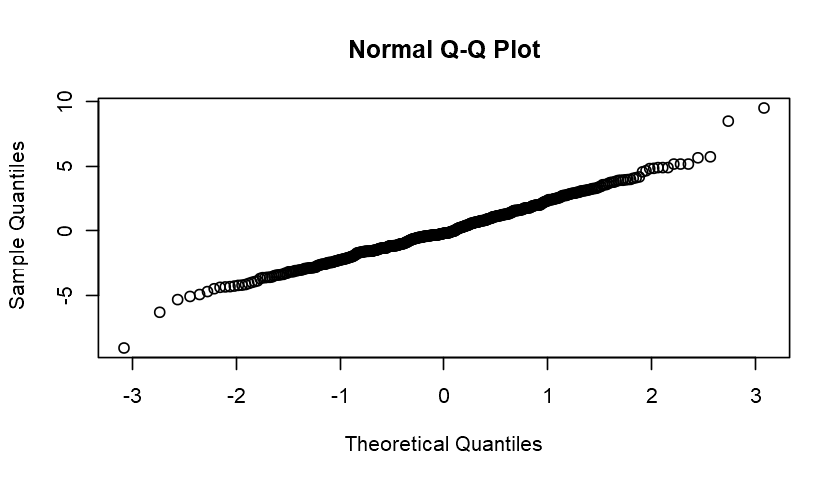

`geom_smooth()` using method = 'loess'


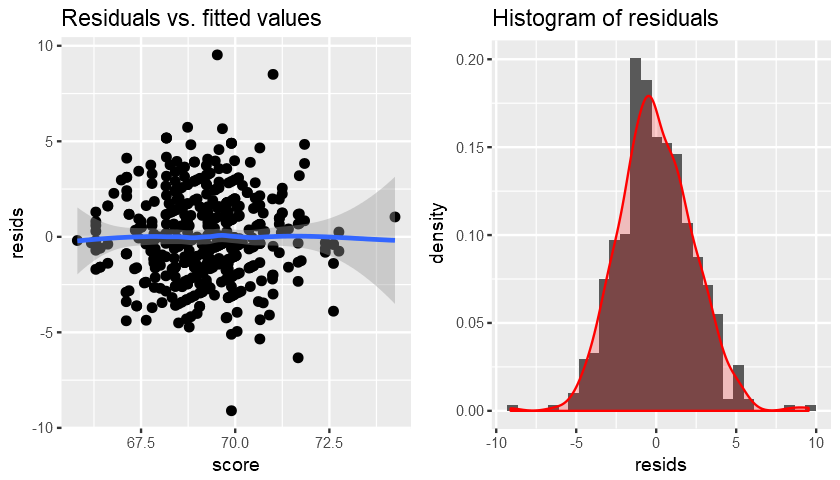

SSE = 786.464830338432 
SSR = 2518.2760012624 
SST = 3304.74083160083 
RMSE = 1.64188899861886 
Adjusted R^2 = 0.231577266155492 


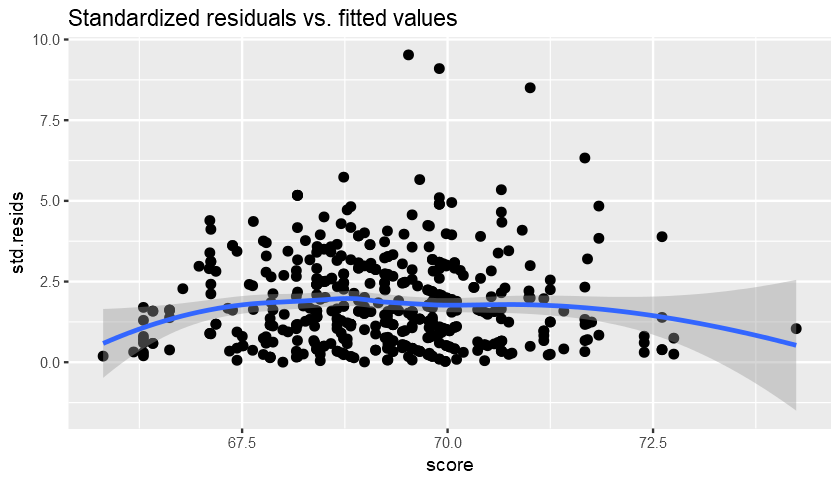

In [81]:
males.ext$score = M %*% bM + mean(males.ext$childHeight)
males.ext$resids = males.ext$score - males.ext$childHeight

require(repr)
options(repr.pmales.extlot.width=8, repr.plot.height=4)

plot.svd.reg <- function(df, k = 4){
  require(ggplot2)
  require(gridExtra)
  
  p1 <- ggplot(df) + 
            geom_point(aes(score, resids), size = 2) + 
            stat_smooth(aes(score, resids)) +
            ggtitle('Residuals vs. fitted values')
 
  p2 <- ggplot(df, aes(resids)) +
           geom_histogram(aes(y = ..density..)) +
           geom_density(color = 'red', fill = 'red', alpha = 0.2) +
           ggtitle('Histogram of residuals')

  qqnorm(df$resids)
    
  grid.arrange(p1, p2, ncol = 2)
    
  df$std.resids = sqrt((df$resids - mean(df$resids))^2)  
    
  p3 = ggplot(df) + 
            geom_point(aes(score, std.resids), size = 2) + 
            stat_smooth(aes(score, std.resids)) +
            ggtitle('Standardized residuals vs. fitted values')
  print(p3) 
    
  n = nrow(df)
  Ybar = mean(df$childHeight)
  SST <- sum((df$childHeight - Ybar)^2)
  SSR <- sum(df$resids * df$resids)
  SSE = SST - SSR
  cat(paste('SSE =', as.character(SSE), '\n'))
  cat(paste('SSR =', as.character(SSR), '\n'))
  cat(paste('SST =', as.character(SSE + SSR), '\n'))
  cat(paste('RMSE =', as.character(SSE/(n - 2)), '\n'))

  adjR2  <- 1.0 - (SSR/SST) * ((n - 1)/(n - k - 1))
  cat(paste('Adjusted R^2 =', as.character(adjR2)), '\n')
}

plot.svd.reg(males.ext)

These results are comparable to the results we obtained by stepwise regression. Evidently, the pseudo inverse method worked rather well. 

## Regularization 2, Ridge and Lasso Regression

So far, we have looked at two approached for dealing with over-parameterized models; feature selection by stepwise regresson and singular value decomposision. In this sectio we will explore the most widely used regularization method for optimization-based machine learning models, ridge regression. 

Let's start by examining the **normal equation** formulation of the linear regresson problem. The goal is to compute a vector of **model coefficients** or weights which minimize the mean squared residuals, given a vector of data $x$ amd a **model matrix** $A$. We can write our model as:

$$x = A b$$

To solve this problem we would ideally like to compute:

$$b = A^{-1}x$$

A commonly used alternative form can help:

$$b = (A^TA)^{-1}A^Tx$$

Now, $A^TA$ is an $m x m$ matrix, and thus is of reduced dimension. But, **$A^TA$ can still be rank deficient!** 

The basic idea of ridge regression is to stabalize the inverse sigular value matrix,$D^+$, by **adding a small bias term**, $\lambda$, to each of the singular values. We can state this operation in matrix notation as follows. We start with a modified form of the normal equations (also know as the **L2 or Euclidean norm** minimization problem):

$$min [\parallel A \cdot x - b \parallel + \parallel \lambda \cdot b\parallel]\\  or \\
b = (A^TA + \lambda^2)^{-1}A^Tx$$

In this way, the values of small signular values do not blow up when we compute the inverse. You can see this by writing out the $D^+$ matrix with the bias term.

$$D_{ridge}^+  = \begin{bmatrix}
    \frac{1}{d_1 + \lambda^2}  & 0 & 0 & \dots & 0 \\
    0  & \frac{1}{d_2 + \lambda^2} & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & \frac{1}{d_m + \lambda^2}
\end{bmatrix}$$

Adding this bias term creates a 'ridge' in the singular value matrix, giving this method its name **ridge regression**. 

You can also think of ridge regression as limiting the L2 or Euclidean norm of the values of the model coeficient vector. The value of $\lambda$ determines how much the norm of the coeficient vector constrains the solution. You can see a view of this geometric interpretaton in the figure below.  

![](img/L2.jpg)
<center> **Geometric view of L2 regularization**

The same method goes by some other names, as it seems to have been 'invented' several times. In particular, **Tikhonov regularization**, or **L2 norm regularization**. In all likelihood the method was first developted by the Russian mathematician Andrey Tikhonov in the late 1940's, and first published in english in 1977.

![](img/Tikhonov_board.jpg)
<center> **Commemorative plaque for Andrey Nikolayevich Tikhonov at Moscow State University**

Let's give this a try. Execute the code in the cell below which computes the $(A^TA + \lambda^2)^{-1}A^T$ matrix with a lambda value of `0.1`.

In [104]:
cat('Compute and print the inverse singular value matrix')
lambda = 100.0
d.trim = 1/ (mSVD$d + lambda)
mD = diag(d.trim)
mD
cat('Compute and print the pseudo inverse')
mInv = mSVD$v %*% mD %*% t(mSVD$u)
mInv
MTMTM = mInv %*% t(M)

Compute and print the inverse singular value matrix

0.0008733018,0.00000000,0.000000000,0.000000000
0.0000000000,0.00102606,0.000000000,0.000000000
0.0000000000,0.00000000,0.009982399,0.000000000
0.0000000000,0.00000000,0.000000000,0.009985826


Compute and print the pseudo inverse

5.466608e-03,-3.305293e-05,-4.517522e-03,-3.597911e-05
-3.305293e-05,5.466229e-03,-3.880173e-05,-4.516902e-03
-4.517522e-03,-3.880173e-05,5.467791e-03,-4.492541e-05
-3.597911e-05,-4.516902e-03,-4.492541e-05,5.466959e-03


**Your Turn!:** Compute the model coeficients using the $(A^TA + \lambda^2)^{-1}A^T$ matrix you just computed. Give the result a new name and compare these results to the previously computed model coeficients. Call the new vector of model coeficients `b2`.

In [105]:
b2 = MTMTM %*% males.ext$childHeight
b2

0.3455149
0.4406581
0.3530585
0.4355801


The next step is to compute the score and residuals, along with the model summary. Execute this the code below and compare these results to the one perviously computed. 

`geom_smooth()` using method = 'loess'
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


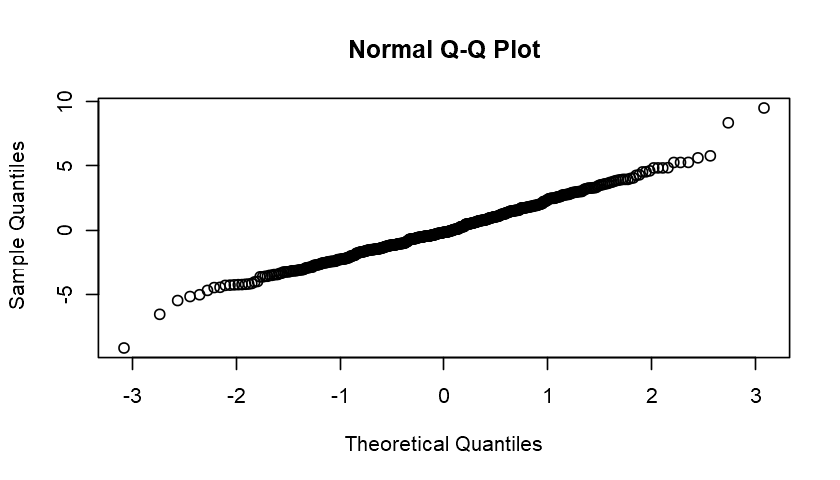

`geom_smooth()` using method = 'loess'


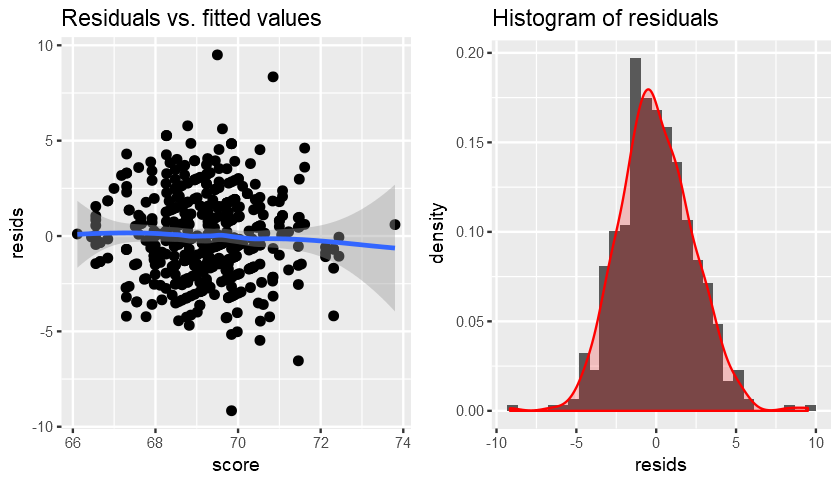

SSE = 780.449570115622 
SSR = 2524.29126148521 
SST = 3304.74083160083 
RMSE = 1.62933104408272 
Adjusted R^2 = 0.229741779218047 


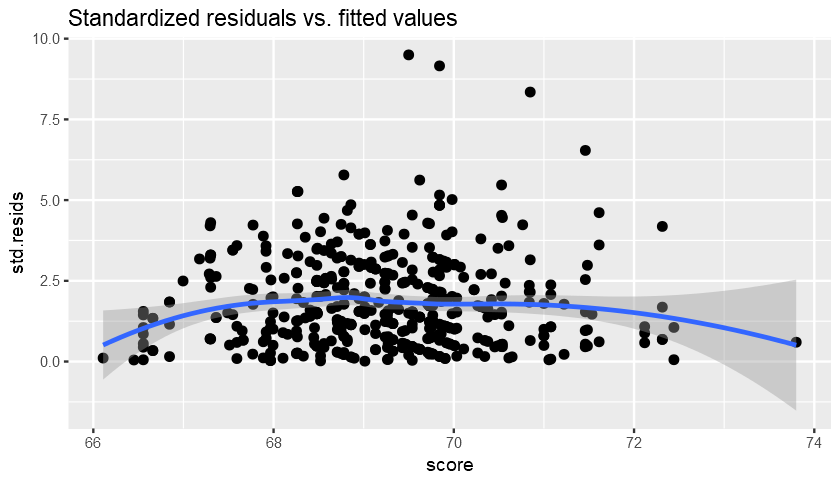

In [106]:
males.ext$score = M %*% b2 + mean(males.ext$childHeight)
males.ext$resids = males.ext$score - males.ext$childHeight

plot.svd.reg(males.ext)

This results are quite similar to those computed using the SVD truncation method. Both results provide resonable regularizaitons. 

**Your Turn:** Create a new ridge regression model using $\lambda = 1.0$. Compare the new model to the models computed before.

Compute and print the inverse singular value matrix

0.0009559503,0.000000000,0.0000000,0.0000000
0.0000000000,0.001142071,0.0000000,0.0000000
0.0000000000,0.000000000,0.8501111,0.0000000
0.0000000000,0.000000000,0.0000000,0.8757026


Compute and print the pseudo inverse

0.434203938,-0.005450602,-0.433223247,0.006063134
-0.005450602,0.429635527,0.005788032,-0.428633763
-0.433223247,0.005788032,0.434341006,-0.006586835
0.006063134,-0.428633763,-0.006586835,0.429731186


0.0791961
0.7157124
0.6841287
0.2445833


`geom_smooth()` using method = 'loess'
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


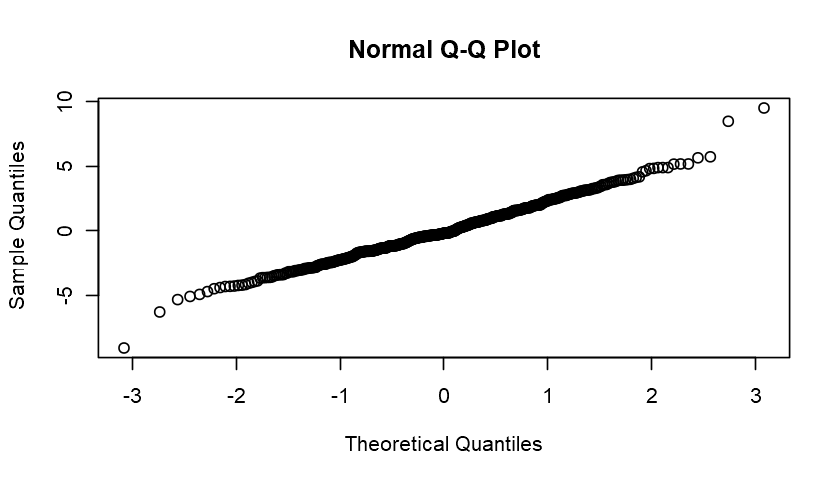

`geom_smooth()` using method = 'loess'


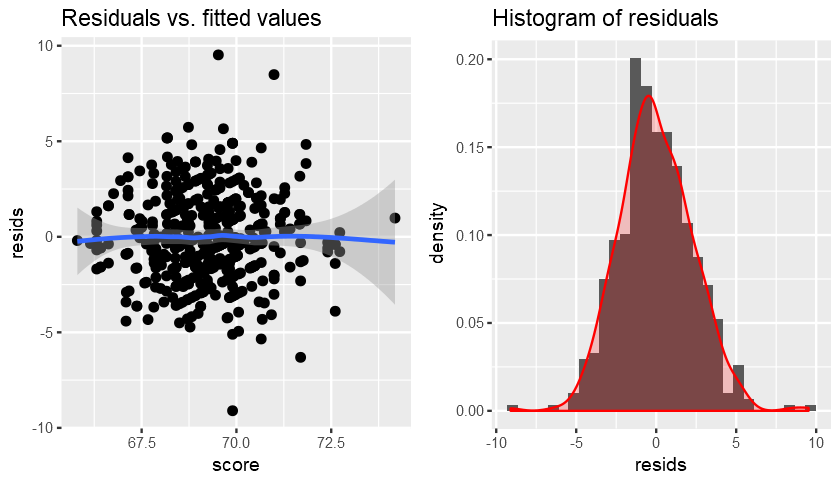

SSE = 787.093177405736 
SSR = 2517.6476541951 
SST = 3304.74083160083 
RMSE = 1.64320078790341 
Adjusted R^2 = 0.231768998980257 


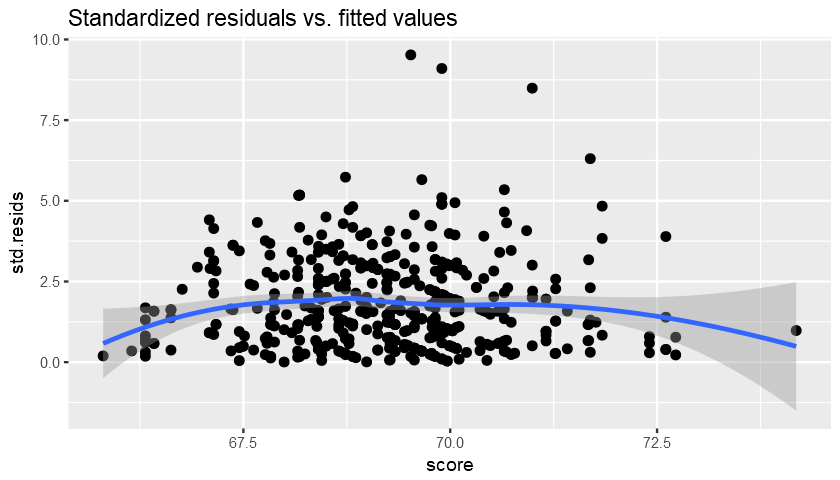

In [107]:
cat('Compute and print the inverse singular value matrix')
lambda = 1.0
d.trim = 1/ (mSVD$d + lambda)
mD = diag(d.trim)
mD
cat('Compute and print the pseudo inverse')
mInv = mSVD$v %*% mD %*% t(mSVD$u)
mInv
MTMTM = mInv %*% t(M)

b2 = MTMTM %*% males.ext$childHeight
b2

males.ext$score = M %*% b2 + mean(males.ext$childHeight)
males.ext$resids = males.ext$score - males.ext$childHeight

plot.svd.reg(males.ext)

You can see that for small bias terms the solution does not change very much. However, the numeric range of the inverse singular values is much greater. In other words, you are applying much less of a regularization or bias. 

### Bias-variance trade-off

The `glmnet` package, by Hastie and Quinn, allows us to compute a sequence of ridge regression solutions. The code in the cell below computes solutions for `20` values of $\lambda$. Since we are performing linear regression we use a Gaussian model family for the error terms. Execute this code and examine the values of the model coefficients as $\lambda$ increases.

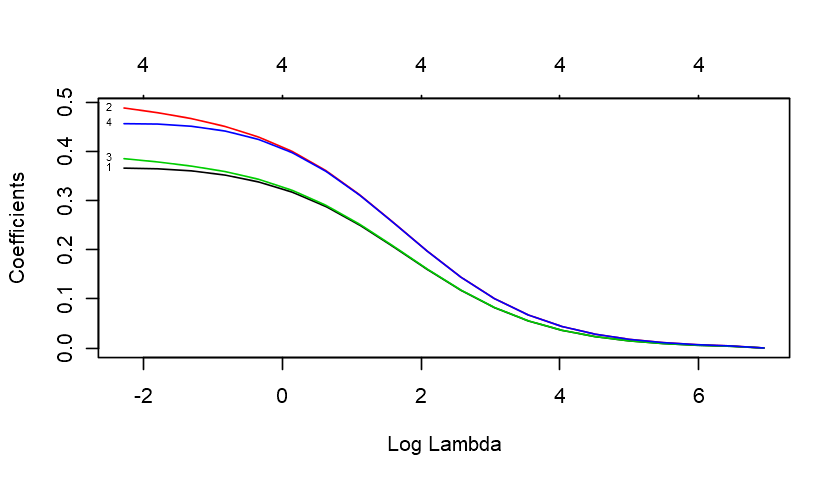

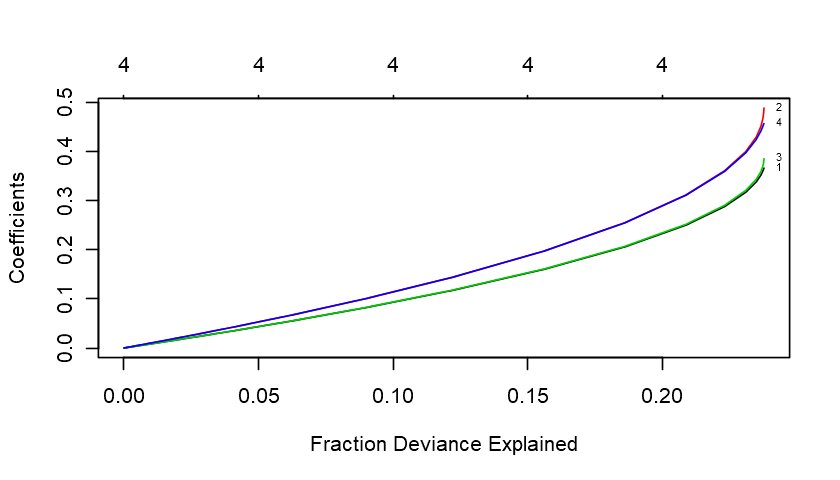

In [86]:
require(glmnet)
b = as.matrix(males.ext$childHeight)
mod.ridge = glmnet(M, b, family = 'gaussian', nlambda = 20, alpha = 0.0)
plot(mod.ridge, xvar = 'lambda', label = TRUE)
plot(mod.ridge, xvar = 'dev', label = TRUE)

Notice that $\lambda$ increases, the values of the 4 model coeficients decrease toward zero. When all coeficients are zero, the model predicts all values of the label as zero! In other words, high values of $\lambda$ give highly biased soluions, but with very low variance. For small values of $\lambda$, the situation is just the oposite. The solution has low bias, but is quite unstable, having maximum variance. This **bias-variance trade off** is a key concept in machine learning. 

### Lasso regression

We can also do regularization using other norms. **Lasso or L1 regularizaton** limits the sum of the absolute values of the model coefients. The L1 norm is sometime know as the **Manhattan norm**, since distrance are measured as if you were traveling on a rectangular grid of streets. 

You can also think of lasso regression as limiting the L1 norm of the values of the model coeficient vector. The value of $\lambda$ determines how much the norm of the coeficient vector constrains the solution. You can see a view of this geometric interpretaton in the figure below.  

![](img/L1.jpg)
<center> **Geometric view of L1 regularization**

By setting the `alpha` argument to `glmnet` to zero you can perform lasso regresson. Execute the code in the cell below to compute and evaluate a lasso regression model with 20 values of lambda.

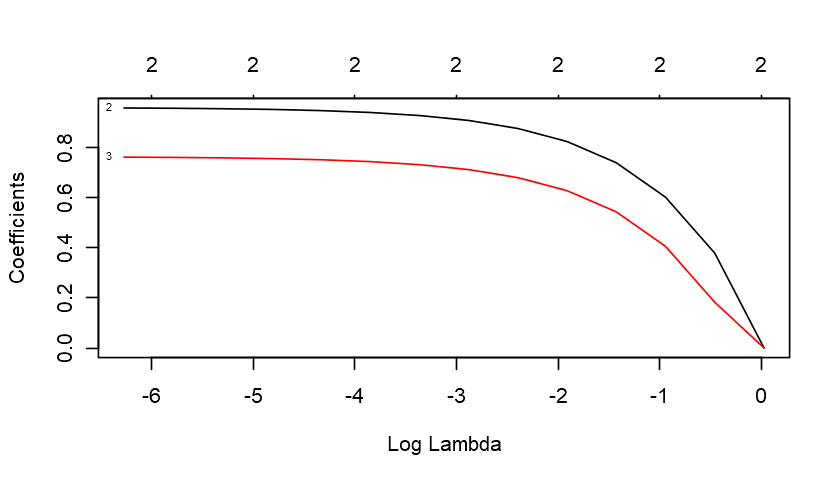

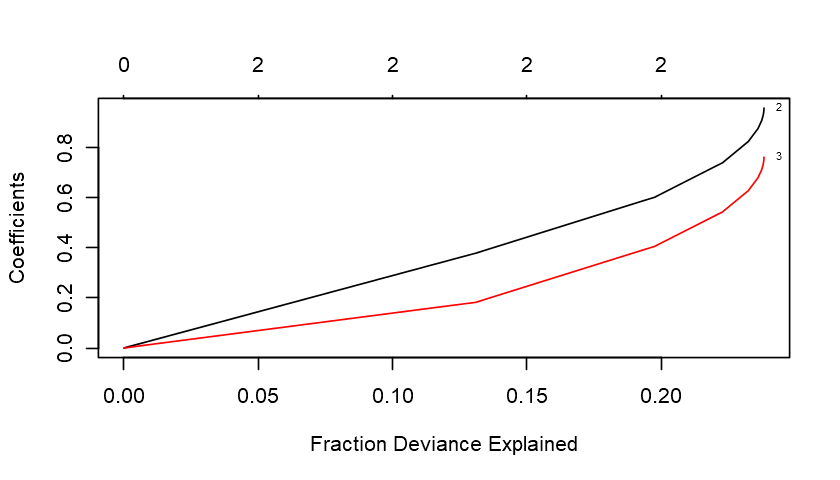

In [87]:
mod.lasso = glmnet(M, b, family = 'gaussian', nlambda = 20, alpha = 1.0)
plot(mod.lasso, xvar = 'lambda', label = TRUE)
plot(mod.lasso, xvar = 'dev', label = TRUE)

Notice that model coeficients are much more tightly constrianed than for L2 regularization. In fact, only two of the possible model coeficients have non-zero values at all. This is typical of L1 or lasso regression.

### Elastic net regression

The **elastic net** algorthm uses a weighted combination of L2 and L1 regularization. The `alpha` argument to the `glmnet` function determines the relative weight of the two methods. If `alpha = 0`, the regularization is pure L2 and if `alpha = 1.0` the regularization is pure L1. 

The code in the cell below gives equal weight to each regression method. Excute this code and examine the results.

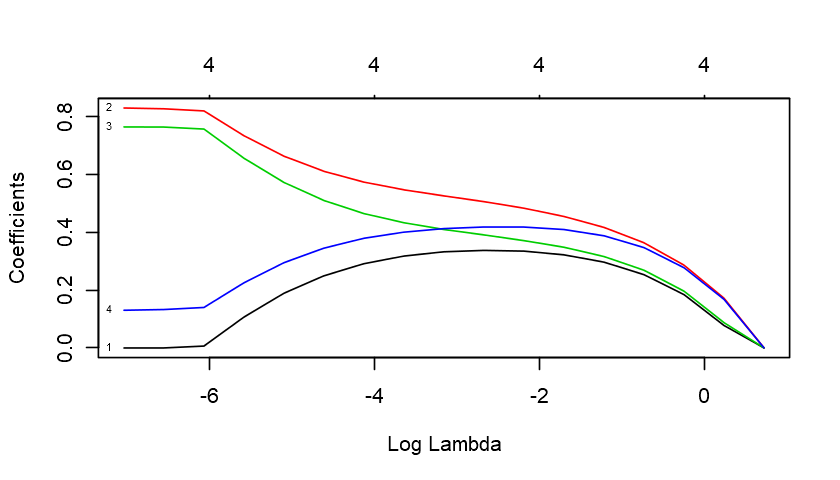

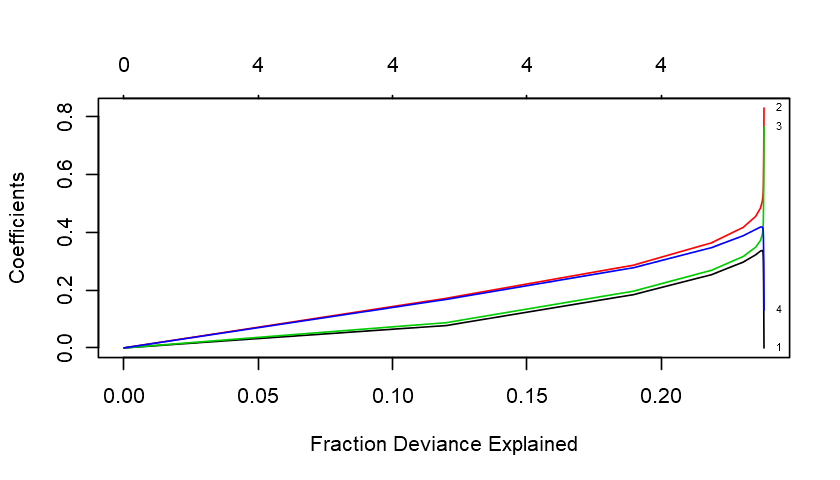

In [88]:
mod.ridge.lasso = glmnet(M, b, family = 'gaussian', nlambda = 20, alpha = 0.5)
plot(mod.ridge.lasso, xvar = 'lambda', label = TRUE)
plot(mod.ridge.lasso, xvar = 'dev', label = TRUE)

Notice that the elastic net model combines some of the behaviors of both L2 and L1 regularization. 

As a next step, we will evaluate this model by the following steps.
- Create a score vector using the `predict` method on the model and using the original model matrix.
- Compute residuals.
- Plot and print summaries of the model performance.

Run this code and examine the results.

`geom_smooth()` using method = 'loess'
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


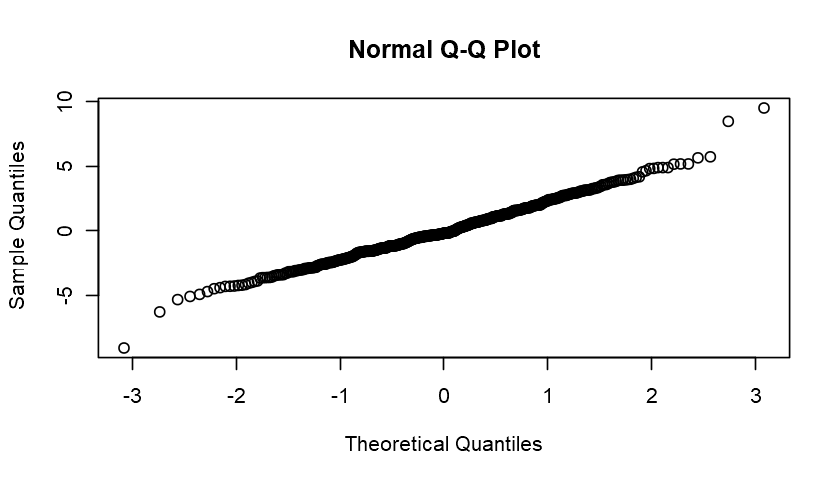

`geom_smooth()` using method = 'loess'


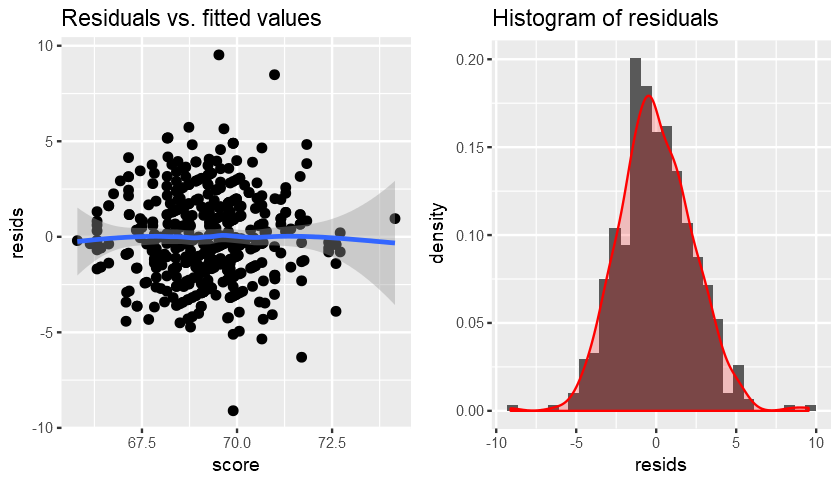

SSE = 787.273765637227 
SSR = 2517.4670659636 
SST = 3304.74083160083 
RMSE = 1.64357779882511 
Adjusted R^2 = 0.231824103385998 


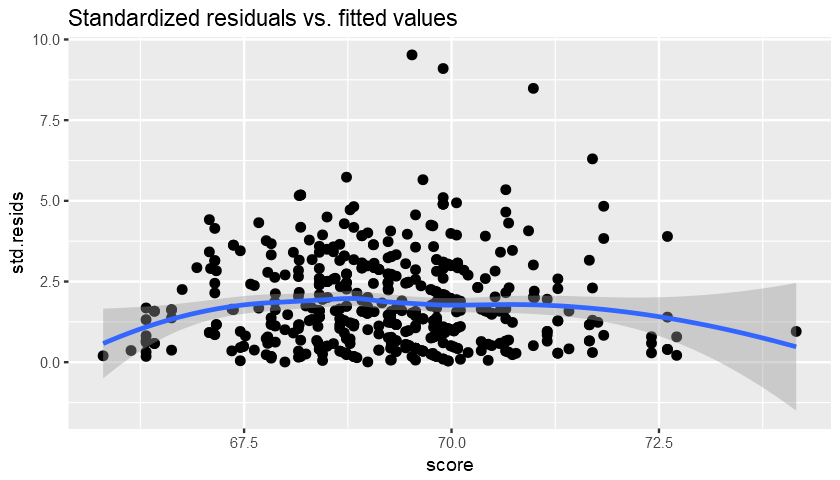

In [89]:
males.ext$score = predict(mod.ridge.lasso, newx = M)[, 15]
males.ext$resids = males.ext$score - males.ext$childHeight

plot.svd.reg(males.ext)

The results are similar to those obtained using both stepwise regression and the pseudo inverse method. For this small problem all three methods seem to work.

## Categorical Variables and the Model Matrix

Up until now we have only been working with numeric data. How can we handle categorical variables in numeric models? 

We need to encode the categorical variables into one or more numeric variables. The common approach is to convert the categorical variable to a set of binary **dummy variables** or **indicator variables**. 

In R, and some other analytical software, this is done automatically. In R we can use the `model.matrix` function to compute and view the result explicitly. 

The code in the cell below computes the scaled model data frame. Execute this code and examine the summary of the data frame.

In [90]:
Galton.scaled = GaltonFamilies[, c('mother', 'father', 'childHeight', 'gender')]
Galton.scaled = mutate(Galton.scaled, 
                       mother.sqr = mother^2, father.sqr = father^2)
Galton.scaled[, c('mother', 'father', 'mother.sqr', 'father.sqr')] = 
        lapply(Galton.scaled[, c('mother', 'father', 'mother.sqr', 'father.sqr')], 
               scale)
str(Galton.scaled)

'data.frame':	934 obs. of  6 variables:
 $ mother     : num [1:934, 1] 1.27 1.27 1.27 1.27 1.05 ...
  ..- attr(*, "scaled:center")= num 64.1
  ..- attr(*, "scaled:scale")= num 2.29
 $ father     : num [1:934, 1] 3.76 3.76 3.76 3.76 2.55 ...
  ..- attr(*, "scaled:center")= num 69.2
  ..- attr(*, "scaled:scale")= num 2.48
 $ childHeight: num  73.2 69.2 69 69 73.5 72.5 65.5 65.5 71 68 ...
 $ gender     : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 1 1 2 1 ...
 $ mother.sqr : num [1:934, 1] 1.29 1.29 1.29 1.29 1.06 ...
  ..- attr(*, "scaled:center")= num 4113
  ..- attr(*, "scaled:scale")= num 292
 $ father.sqr : num [1:934, 1] 3.98 3.98 3.98 3.98 2.64 ...
  ..- attr(*, "scaled:center")= num 4794
  ..- attr(*, "scaled:scale")= num 344


Categorical (factor) variables are converted to one or more dummy variables. 

Execute the  code in the cell below and examine the results. 

In [91]:
mod.mat = model.matrix(childHeight ~ ., data = Galton.scaled)
mod.mat[1:10, ]

,(Intercept),mother,father,gendermale,mother.sqr,father.sqr
1,1,1.27055924,3.756498,1,1.28811568,3.980033
2,1,1.27055924,3.756498,0,1.28811568,3.980033
3,1,1.27055924,3.756498,0,1.28811568,3.980033
4,1,1.27055924,3.756498,0,1.28811568,3.980033
5,1,1.05230309,2.545101,1,1.05963530,2.635785
6,1,1.05230309,2.545101,1,1.05963530,2.635785
7,1,1.05230309,2.545101,0,1.05963530,2.635785
8,1,1.05230309,2.545101,0,1.05963530,2.635785
9,1,-0.03897765,2.343202,1,-0.05709464,2.416836
10,1,-0.03897765,2.343202,0,-0.05709464,2.416836


In [92]:
typeof(mod.mat[, 4])

[1] "double"

Notice that the categorical variable `gender` is now coded as a single numeric variable with two possible values.

**Your Turn:** Create and execute the code to print the first few lines of a the model matrix without an intercept term. **Hint**, you need to add `-1` to the model formula to drop the intercept term.

In [93]:
model.matrix(childHeight ~ . - 1, data = Galton.scaled)[1:10,]

,mother,father,genderfemale,gendermale,mother.sqr,father.sqr
1,1.27055924,3.756498,0,1,1.28811568,3.980033
2,1.27055924,3.756498,1,0,1.28811568,3.980033
3,1.27055924,3.756498,1,0,1.28811568,3.980033
4,1.27055924,3.756498,1,0,1.28811568,3.980033
5,1.05230309,2.545101,0,1,1.05963530,2.635785
6,1.05230309,2.545101,0,1,1.05963530,2.635785
7,1.05230309,2.545101,1,0,1.05963530,2.635785
8,1.05230309,2.545101,1,0,1.05963530,2.635785
9,-0.03897765,2.343202,0,1,-0.05709464,2.416836
10,-0.03897765,2.343202,1,0,-0.05709464,2.416836


Notice how the coding of the `gender` feature has changed. Why do you think this is?

Now, it is time to compute and evaluate the model. The code in the cell below does the following:
- Compute the model.
- Compute the scores from the model using the original model matrix.
- Compute the residuals.
- Plot and print model performance diagnositics. 

Execute this code and examine the results.

`geom_smooth()` using method = 'loess'
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


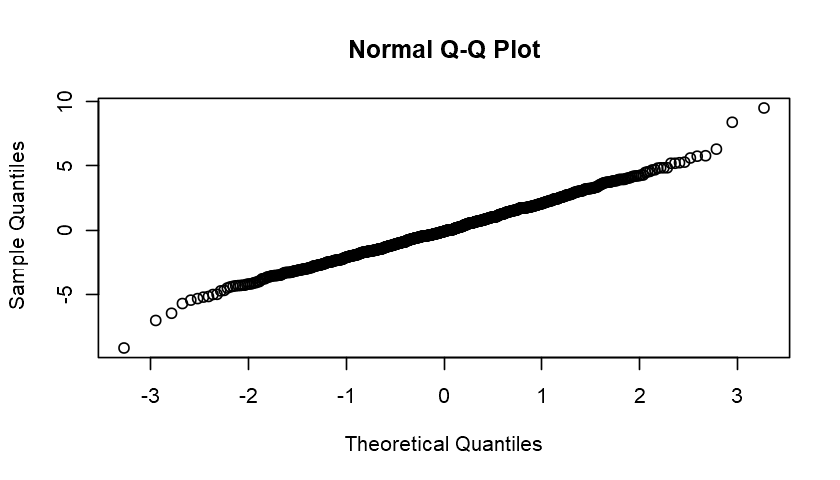

`geom_smooth()` using method = 'loess'


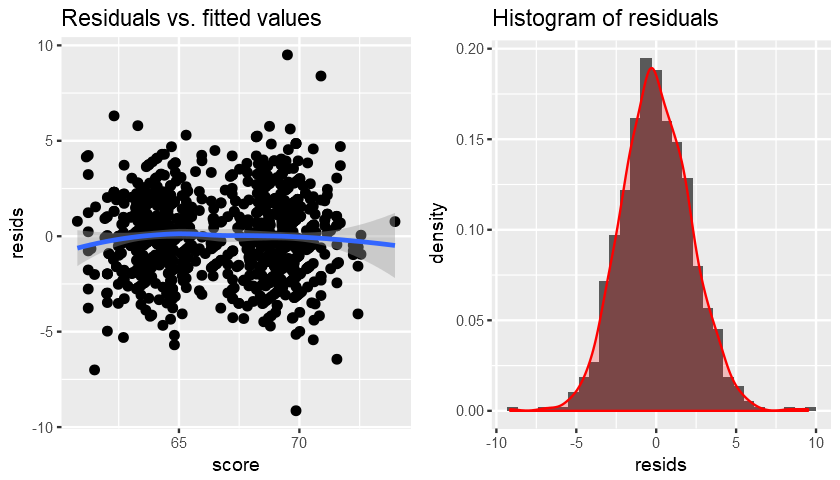

SSE = 7597.1692655579 
SSR = 4355.53027405666 
SST = 11952.6995396146 
RMSE = 8.15146916905355 
Adjusted R^2 = 0.63403381066381 


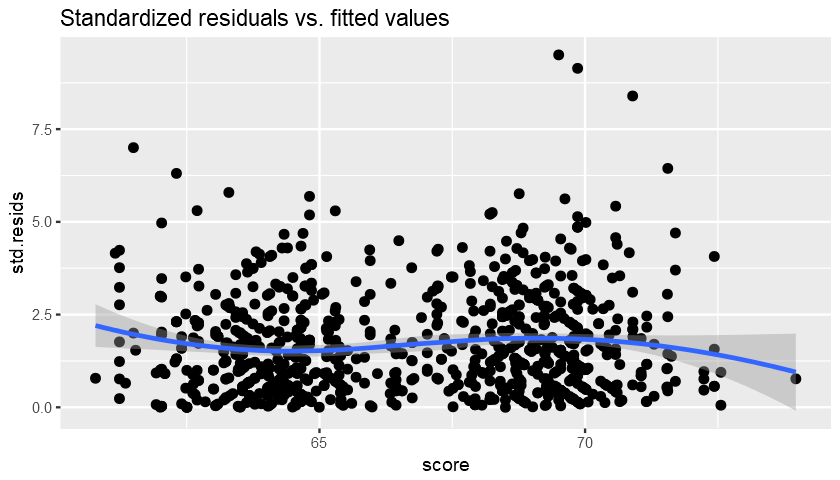

In [94]:
b.mat = as.matrix(Galton.scaled$childHeight)
mod.ridge.gender = glmnet(mod.mat, b.mat, family = 'gaussian', 
                          nlambda = 20, alpha = 0.5)

Galton.scaled$score = predict(mod.ridge.gender, newx = mod.mat)[, 15]
Galton.scaled$resids = Galton.scaled$score - Galton.scaled$childHeight

plot.svd.reg(Galton.scaled)

Notice, that this model has both a larger $R^2$ and RMSE. Why do you think this is?

**Your Turn:** For the model you have just created plot the model coeficients vs. $\lambda$ and the deviance vs. $\lambda$. How can you interpret these result with particular attention on the categorical feature, 4.

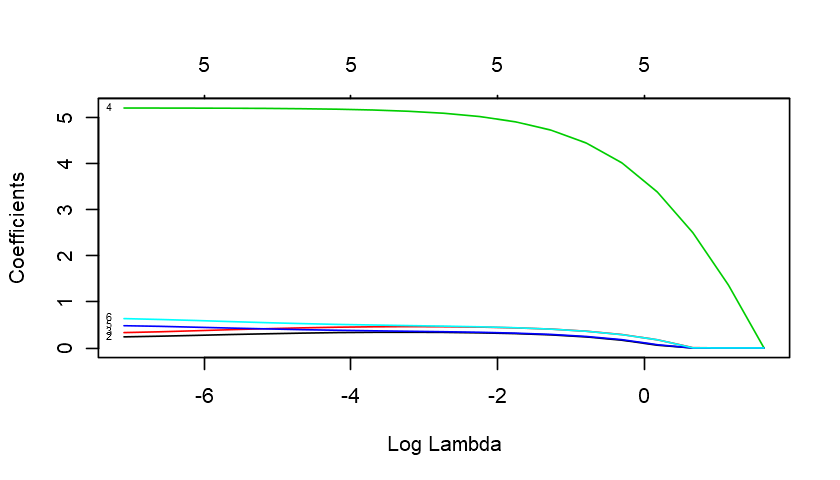

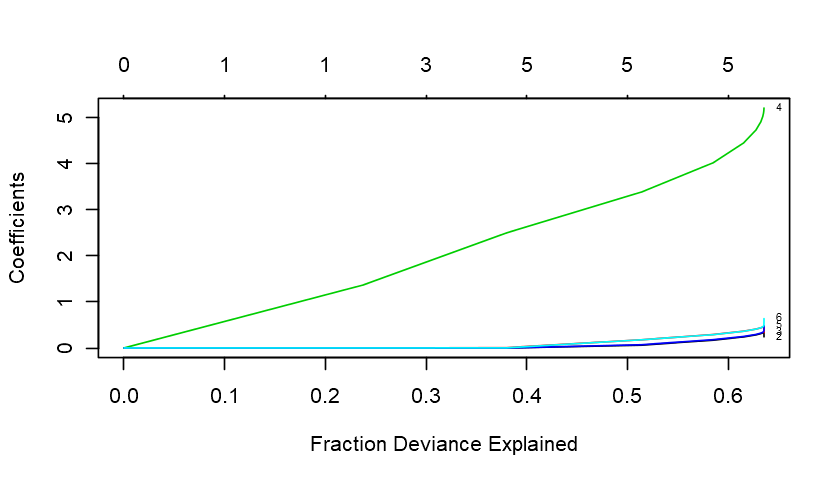

In [95]:
plot(mod.ridge.gender, xvar = 'lambda', label = TRUE)
plot(mod.ridge.gender, xvar = 'dev', label = TRUE)

## Logistic Regresson

Untill now, we have been working strictly with linear regression models. Now we will look at a widely used variation on the linear model know as **logistic regresson**.

Logistic regression is widely used as a classification model. Logistic regression is linear model, with a binary response, `{False, True}` or `{0, 1}`.  However, the response is computed as a log likelihood. In the simplest case, the response has a Binomial distribution. 

The response of the linear model is transformed to the log likelihood using a sigmodial function, also know as the **logistic function**:

$$f(x) = \frac{1}{1 + e^{-\kappa(x - x_0)}} \\
\kappa = steepness$$

Execute the code in the cell below to compute and plot an example of the logistic function.

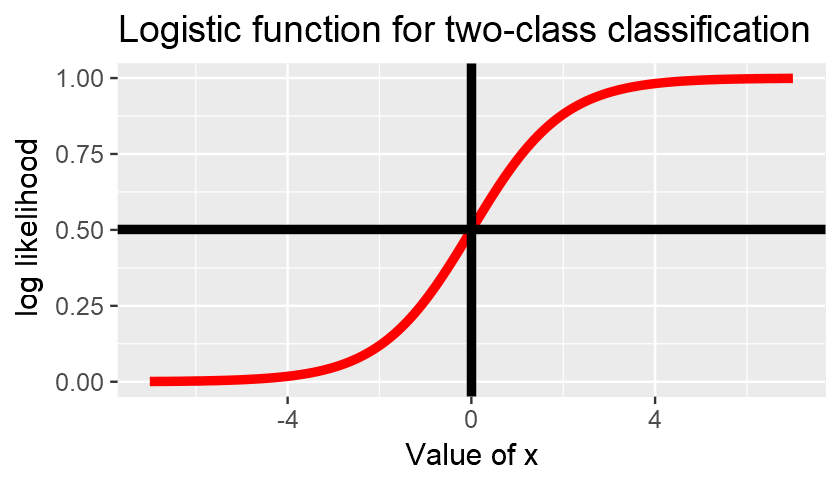

In [96]:
options(repr.pmales.extlot.width=6, repr.plot.height=4)

xseq = seq(-7, 7, length.out = 500)
plot.logistic = function(v){
  require(ggplot2)
  logistic = exp(xseq - v)/(1 + exp(xseq - v))
  df = data.frame(x = xseq, y = logistic)
  ggplot(df, aes(x,y)) +
    geom_line(size = 2, color = 'red') +
    geom_vline(xintercept = v, size = 2, color = 'black') +
    geom_hline(yintercept = 0.5, size = 2, color = 'black') +
    ylab('log likelihood') + xlab('Value of x') +
    ggtitle('Logistic function for two-class classification') +
    theme_grey(base_size = 18)
}
plot.logistic(0)

Let's make this a bit more concrete with a simple example. Say we have a linear model:

$$\hat{y} = \beta_0 + \beta_1\ x$$

Now, depending on the value of $\hat{y}$ we want to classify the output from a logistic regression model as either `0` or `1`. We can use the linear model in the logistic function as follows:

$$F(\hat{y}) = \frac{1}{1 + e^{-\kappa(\beta_0 + \beta_1\ x)}} $$

In this way we transform the continious output of the linear model defined on $-\infty \le \hat{y} \le \infty$ to a binary response, $0 \le F(\hat{y}) \le 1$

### Clasification Example

Next, we will try to classify the gender of the childern in the Gaulton families data set using logistic regression on the height data.

As a first step, we need to create a scaled model matrix of the features for the logistic regression. Run the code in the cell bellow to compute this matrix.

In [97]:
Galton.gender = GaltonFamilies[, c('mother', 'father', 'childHeight', 'gender')]
Galton.gender[, c('mother', 'father', 'childHeight')] = 
        lapply(Galton.gender[, c('mother', 'father', 'childHeight')], 
               scale)
mod.gender = model.matrix(gender ~ ., data = Galton.gender)
mod.gender[1:10, ]

,(Intercept),mother,father,childHeight
1,1,1.27055924,3.756498,1.8031896
2,1,1.27055924,3.756498,0.6856374
3,1,1.27055924,3.756498,0.6297598
4,1,1.27055924,3.756498,0.6297598
5,1,1.05230309,2.545101,1.8870060
6,1,1.05230309,2.545101,1.6076180
7,1,1.05230309,2.545101,-0.3480984
8,1,1.05230309,2.545101,-0.3480984
9,1,-0.03897765,2.343202,1.1885359
10,1,-0.03897765,2.343202,0.3503718


The code in the cell below using the `glmnet` function to compute the regression of to predict gender using a binomial distribution. The score or response is then computed and printed. Execute this code and examine the results.

In [98]:
require(glmnet)
b.gender = as.matrix(Galton.gender$gender)
b.gender = ifelse(b.gender == 'male', 1, 0)
mod.class = glmnet(mod.gender, b.gender, family = 'binomial', 
                          nlambda = 20, alpha = 0.5)

Galton.gender$score = predict(mod.class, newx = mod.gender)[, 15]
Galton.gender[1:10, c('score', 'gender')]

score,gender
2.1080826,male
-2.0947174,female
-2.3048574,female
-2.3048574,female
3.8602659,male
2.8095659,male
-4.5453341,female
-4.5453341,female
2.2985129,male
-0.8535871,female


Next we need to transfom the response to the binary output using the logistic function. The code in the cell below applies the logistic transformation and sets the categories for the score. Run this code and  examine the result.

In [99]:
Galton.gender$score = exp(Galton.gender$score)/(1 + exp(Galton.gender$score))
Galton.gender$score = ifelse(Galton.gender$score > 0.5, "male", "female")
Galton.gender[1:10, c('score', 'gender')]

score,gender
male,male
female,female
female,female
female,female
male,male
male,male
female,female
female,female
male,male
female,female


The code in the cell below computes some common performance statistics for binary classifiers. The overall performance of the binary classifier is summarized by the elements of a **confusion matrix**. 

Run this code and examine the results.

In [100]:
logistic.eval <- function(df){ 
  # First step is to find the TP, FP, TN, FN cases
  df$conf <- ifelse(df$gender == 'male' & df$score == 'male', 'TP',
                    ifelse(df$gender == 'female' & df$score == 'male', 'FP',
                           ifelse(df$gender == 'female' & df$score == 'female', 'TN', 'FN')))

  # Elements of the confusion matrix
  TP = length(df[df$conf == 'TP', 'conf'])
  FP = length(df[df$conf == 'FP', 'conf'])
  TN = length(df[df$conf == 'TN', 'conf'])
  FN = length(df[df$conf == 'FN', 'conf'])
    
  out <- data.frame(Positive = c(TP, FP), Negative = c(FN, TN))
  row.names(out) <- c('TruePos', 'TrueNeg')
  print(out)  
  
  # Compute and rint metrics
  cat('\n')
  cat(paste('accuracy =', as.character((TP + TN)/(TP + TN + FP + FN)), '\n'))      
  cat(paste('precision =', as.character(signif(TP/(TP + FP)), digits = 2)), '\n')     
  cat(paste('recall =', as.character(TP/(TP + FN))))
}
logistic.eval(Galton.gender)

        Positive Negative
TruePos      422       59
TrueNeg       47      406

accuracy = 0.886509635974304 
precision = 0.899787 
recall = 0.877338877338877

In the confusion matrix males are defined as Positive cases and females are Negtive cases. Notice that most of the cases in this data are correctly classified with only a few false negatives and false positives.

The other metrics are defined as follows:

- Accuracy = (TP + TN) / (TP + FP + TN + FN)
- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)

These summary statistics show the classifier works fairly well.

#### Copyright 2017, Stephen F Elston. All rights reserved.